# Text Classification

# Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="`np.bool8` is a deprecated alias for `np.bool_`.")
warnings.filterwarnings("ignore", category=DeprecationWarning, message="`np.bool8` is a deprecated alias")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="bokeh")
warnings.filterwarnings("ignore", message="`should_run_async` will not call `transform_cell` automatically in the future")

import logging
logging.getLogger('gensim').setLevel(logging.ERROR)

import os
import requests
from bs4 import BeautifulSoup
from lxml import html
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim import models
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from collections import Counter
from pprint import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
import lda

In [9]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA

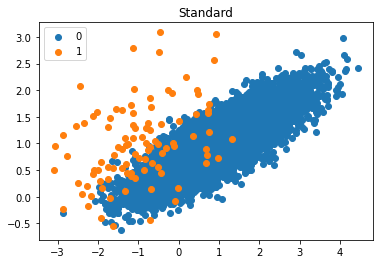

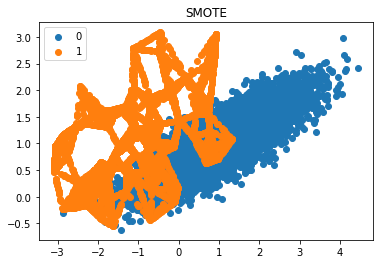

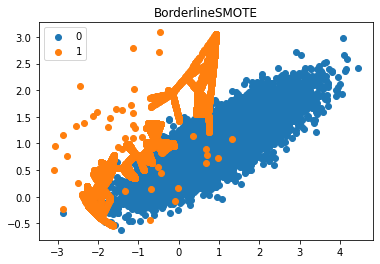

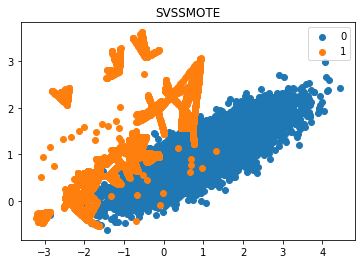

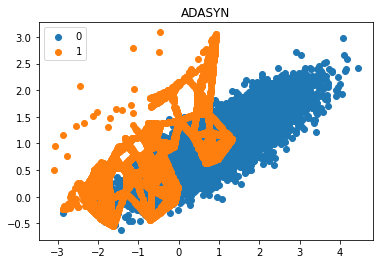

In [10]:
# define dataset
x, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# transform the dataset
oversample_1 = SMOTE()
oversample_2 = BorderlineSMOTE()
oversample_3 = SVMSMOTE()
oversample_4 = ADASYN()
x1, y1 = oversample_1.fit_resample(x, y)
x2, y2 = oversample_2.fit_resample(x, y)
x3, y3 = oversample_3.fit_resample(x, y)
x4, y4 = oversample_4.fit_resample(x, y)

# summarize the new class distribution
counter = Counter(y)
counter_1 = Counter(y1)
counter_2 = Counter(y2)
counter_3 = Counter(y3)
counter_4 = Counter(y4)

# scatter plot of examples by class label    
for label in counter.keys():
    row_ix = np.where(y == label)[0]
    plt.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label))
plt.legend()
plt.title('Standard')
plt.show()

for label in counter_1.keys():
    row_ix = np.where(y1 == label)[0]
    plt.scatter(x1[row_ix, 0], x1[row_ix, 1], label=str(label))
plt.legend()
plt.title('SMOTE')
plt.show()

for label in counter_2.keys():
    row_ix = np.where(y2 == label)[0]
    plt.scatter(x2[row_ix, 0], x2[row_ix, 1], label=str(label))
plt.legend()
plt.title('BorderlineSMOTE')
plt.show()

for label in counter_3.keys():
    row_ix = np.where(y3 == label)[0]
    plt.scatter(x3[row_ix, 0], x3[row_ix, 1], label=str(label))
plt.legend()
plt.title('SVSSMOTE')
plt.show()

for label in counter_4.keys():
    row_ix = np.where(y4 == label)[0]
    plt.scatter(x4[row_ix, 0], x4[row_ix, 1], label=str(label))
plt.legend()
plt.title('ADASYN')
plt.show()

In [50]:
def smote_simulation(over_model):
    
    # define dataset
    x, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                               n_clusters_per_class=1, weights=[0.99], flip_y = 0)
    
    #define pipeline
    model = DecisionTreeClassifier()
    if over_model == '':
        steps = [('model', model)]
        pipeline = Pipeline(steps=steps)
    else:
        over = over_model
        under = RandomUnderSampler(sampling_strategy = 0.5)
        steps = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv)
    print(np.mean(scores))

In [52]:
#No SMOTE
print('Standard:')
smote_simulation('')

# SMOTE
print('SMOTE:')
smote_simulation(SMOTE(sampling_strategy = 0.1))

#BorderlineSMOTE
print('BorderlineSMOTE:')
smote_simulation(BorderlineSMOTE(sampling_strategy = 0.1))

#SVMSMOTE
print('SVMSMOTE:')
smote_simulation(SVMSMOTE(sampling_strategy = 0.1))

#ADASYN
print('ADASYN:')
smote_simulation(ADASYN(sampling_strategy = 0.1))

Standard:
0.9996666666666666
SMOTE:
0.945
BorderlineSMOTE:
0.9765999999999999
SVMSMOTE:
0.9999333333333333
ADASYN:
0.9083333333333333


# First Classification

In [23]:
def text_scraping(links):
    
    cases = []
    for i in tqdm(range(len(links))):
        try:
            url = links[i]
            page = requests.get(url)
            soup = BeautifulSoup(page.content, 'html.parser')
            case = soup.find("div", class_ = 'decision-text-content')
            cases.append(case.get_text())
        except:
            cases.append(None)
    return cases

In [24]:
def text_processing(cases):
    
    # List of processed cases
    processed_cases = []

    #Remove non alphabetical characters and tokenization
    for i in tqdm(range(len(cases))):
        processed_case = cases[i].lower()
        processed_case = re.sub('[^a-zA-Z]', ' ', processed_case )
        processed_case = re.sub(r'\s+', ' ', processed_case)

        all_tags = []
        all_sentences = nltk.sent_tokenize(processed_case) # List of sentences

        #Generation of the tags
        for sent in all_sentences:
            tokens = nltk.word_tokenize(sent)
            tags = nltk.pos_tag(tokens)
            all_tags += tags

        #Lemmatization
        lemmatizer = WordNetLemmatizer()

        tags_2 = []
        for i in range(len(all_tags)):
            try:
                if all_tags[i][1] == 'ADV':
                    tag = 'r'
                else:
                    tag = all_tags[i][1][0].lower()
                tags_2.append(lemmatizer.lemmatize(all_tags[i][0], pos = tag))
            except:
                tags_2.append(all_tags[i][0])

        #Remove too short words and stopwords
        all_words = [tags_2[i] for i in range(len(tags_2)) if len(tags_2[i]) > 2 and tags_2[i] not in stopwords.words('english')]
        processed_cases.append(all_words)
    return processed_cases

In [7]:
# Dataset Generation

d1 = pd.read_excel('KeyBrutality-Oct2012.xlsx')
d2 = pd.read_excel('KeyBrutality-May2017.xlsx')
d3 = pd.concat([d1, d2]).reset_index(drop = True)
d3 = d3[d3['URL'].notnull()]
d3.head()

,URL,Decision Date,Case Number,Personal Ruling,Notes,Brutality Ruling,Brutality Word Count,Police Word Count,Brutality Citation Count,Brutality Instances,Police Instances,Brutality in Citation Sentence,Amendment Word Count,Summary Brutality Word Count,Summary Police Word Count
0,https://www.leagle.com/decision/infco20200902106,"Argued and Submitted October 18, 2012.",No. 09-73088.,,,0.0,0.0,0.0,0.0,[],[],[],0.0,0.0,0.0
1,https://www.leagle.com/decision/infco20150514111,"Argued October 11, 2012.","Nos. 06-50677, 07-50037, 06-50678, 06-50679.",,,0.0,0.0,74.0,0.0,[],"[""We issued an unpublished memorandum disposit...",[],0.0,0.0,1.0
2,https://www.leagle.com/decision/infco20130109084,"Argued: October 24, 2012.",No. 11-2078.,,,0.0,0.0,0.0,0.0,[],[],[],0.0,0.0,0.0
3,https://www.leagle.com/decision/infco20150318140,"Argued and Submitted October 3, 2012.","Nos. 11-35914, 11-35931.",,,0.0,0.0,6.0,0.0,[],['Metro\'s general manager concurred in the p...,[],0.0,0.0,0.0
4,https://www.leagle.com/decision/infco20150226129,"Argued: October 3, 2012.",Docket No. 11-2610-cv.,,,0.0,0.0,28.0,0.0,[],['She described her attacker to a police detec...,[],14.0,0.0,3.0


In [11]:
brutality = d3[d3['Brutality Ruling'] == 1].reset_index(drop = True)
no_brutality = d3[d3['Brutality Ruling'] == 0].reset_index(drop = True)

cases = []
labels = []

for i in tqdm(range(len(brutality['URL']))):
    try:
        url = d3.loc[i, 'URL']
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        case = soup.find("div", class_ = 'decision-text-content')
        cases.append(case.get_text())
        labels.append(1)
    except:
        pass
        
indexes = np.random.choice(len(no_brutality['URL']), size = len(cases), replace = False)
for index in tqdm(range(len(indexes))):
    try:
        url = no_brutality.loc[index, 'URL']
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        case = soup.find("div", class_ = 'decision-text-content')
        cases.append(case.get_text())
        labels.append(0)
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:50<00:00,  1.51it/s]


In [12]:
processed_cases = text_processing(cases)

100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [11:36<00:00,  4.52s/it]


In [13]:
text_cases = [' '.join(processed_cases[i]) for i in range(len(processed_cases))]

In [38]:
#Tf-idf method

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(text_cases).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1)

classifier = RandomForestClassifier(n_estimators=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [39]:
print(list(y_pred))
print(y_test)

[1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [40]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[0 6]
 [9 1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.14      0.10      0.12        10

    accuracy                           0.06        16
   macro avg       0.07      0.05      0.06        16
weighted avg       0.09      0.06      0.07        16

0.0625


In [41]:
# With doc2vec

docs = []
for i in tqdm(range(len(processed_cases))):
    docs.append(TaggedDocument(processed_cases[i], [i]))
    
model = Doc2Vec(docs, vector_size=50, min_count=2)

100%|██████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 2080.60it/s]


# Classification

## Training Data Preparation

In [18]:
files = os.listdir('Output')
final_file = pd.DataFrame()
for i in tqdm(range(len(files))):
    if files[i][-4:] == 'xlsx':
        file = pd.read_excel(f'Output/{files[i]}')
        final_file = pd.concat([final_file, file])

100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [12:04<00:00,  3.40s/it]


In [21]:
print(final_file.shape)
print(final_file.columns)
final_file.head()

(371741, 55)
Index(['URL', 'Fed Recorder', 'Appellees', 'Appellants', 'Other Parties',
       'Court', 'Case Number', 'Original Decision Date',
       'Second Original Decision Date', 'Third Original Decision Date',
       'Amended Decision Date', 'Second Amended Decision Date',
       'First Decision Date', 'Second Decision Date', 'Third Decision Date',
       'Fourth Decision Date', 'Fifth Decision Date', 'Circuit Judges',
       'Appellee Lawyers', 'Appellant Lawyers', 'Other Lawyers',
       'Decision Writer', 'Dissent Writer', 'Dissent', 'Concurrence Writer',
       'Concurrence', 'Result', 'Cited Cases URLs', 'Number of Cited Cases',
       'Cited Decision Writers, Court, Year', 'Citing Cases',
       'Number of Citing Cases', 'Number of District Court Citations',
       'Number of Circuit Court Citations',
       'Number of U.S. Supreme Court Citations', 'Citing Same Court Cases',
       'Same Court Citing', 'Subsidiary Court Citing', 'Dissent2', 'Amicus',
       'Unpublished', 

,URL,Fed Recorder,Appellees,Appellants,Other Parties,Court,Case Number,Original Decision Date,Second Original Decision Date,Third Original Decision Date,...,F.3d,Word Count,Publi Occurrences,Count Errata,Count Frivolous,Frivolous,Immigration Rule,Brutality Rule,Error,Error Messages
0,https://www.leagle.com/decision/20061350458f3d...,458 F.3d 892 (2006),NaN,NaN,NaN,"United States Court of Appeals, Ninth Circuit",No. 03-99001.,NaN,NaN,NaN,...,1.0,18257.0,['On the basis of Supreme Court precedent'],0.0,0.0,[],NaN,NaN,1.0,"[ModuleNotFoundError(""No module named 'nltk'"",..."
1,https://www.leagle.com/decision/20061508449f3d...,449 F.3d 1059 (2006),NaN,NaN,NaN,"United States Court of Appeals, Ninth Circuit","Nos. 03-50062, 03-50121.",NaN,NaN,NaN,...,1.0,591.0,[],0.0,0.0,[],NaN,NaN,1.0,"[ModuleNotFoundError(""No module named 'nltk'"",..."
2,https://www.leagle.com/decision/20061588439f3d...,439 F.3d 1149 (2006),NaN,NaN,NaN,"United States Court of Appeals, Ninth Circuit","Nos. 02-50084, 02-50089, 02-50093, 02-50102, 0...",NaN,NaN,NaN,...,1.0,14484.0,[' but is unnecessary to the decision in the c...,0.0,0.0,[],NaN,NaN,1.0,"[ModuleNotFoundError(""No module named 'nltk'"",..."
3,https://www.leagle.com/decision/20051578431f3d...,431 F.3d 1147 (2005),NaN,NaN,NaN,"United States Court of Appeals, Ninth Circuit",No. 02-30375.,NaN,NaN,NaN,...,1.0,4058.0,['. Whether the technique has been subject to ...,0.0,0.0,[],NaN,NaN,1.0,"[ModuleNotFoundError(""No module named 'nltk'"",..."
4,https://www.leagle.com/decision/20051609428f3d...,428 F.3d 1181 (2005),NaN,NaN,NaN,"United States Court of Appeals, Ninth Circuit","Nos. 02-99002, 02-99003.",NaN,NaN,NaN,...,1.0,13669.0,[' imposing such a requirement would conflict ...,0.0,0.0,[],NaN,NaN,1.0,"[ModuleNotFoundError(""No module named 'nltk'"",..."


In [22]:
#final_file.to_csv('All_Cases.csv')

## Training Set 

In [9]:
all_cases = pd.read_csv('All_Cases.csv').drop('Unnamed: 0', axis = 1)
all_cases = all_cases[all_cases['Brutality Rule'].notnull()].reset_index(drop = True)
print(all_cases.shape)

(361961, 55)


In [10]:
print('% of positives: ', str(all_cases[all_cases['Brutality Rule'] == 1].shape[0]*100/all_cases.shape[0]))
print('% of negatives: ', str(all_cases[all_cases['Brutality Rule'] == 0].shape[0]*100/all_cases.shape[0]))

% of positives:  1.5587314655446305
% of negatives:  98.44126853445538


There's a strong imbalance between positives and negatives, therefore a random subsample of negatives is selected.

In [11]:
pos_ind = np.array(all_cases[all_cases['Brutality Rule'] == 1].index)
neg_ind = np.array(all_cases[all_cases['Brutality Rule'] == 0].index)
neg_ind = np.random.choice(neg_ind, size = int(len(pos_ind)*1.3), replace = False)

pos_links = all_cases[all_cases['Brutality Rule'] == 1].reset_index(drop = True)
neg_links = all_cases.iloc[neg_ind, :].reset_index(drop = True)

In [17]:
# Positive Cases

cases = []
labels = []
urls = []
n = 2000
n2 = 3500

for i in tqdm(range(n2, pos_links.shape[0])):
    try:
        url = pos_links.loc[i, 'URL']
        urls.append(url)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        case = soup.find("div", class_ = 'decision-text-content')
        cases.append(case.get_text())
        labels.append(1)
    except:
        pass

pos_cases = pd.DataFrame()
pos_cases['Case Text'] = cases
pos_cases['Labels'] = labels
pos_cases['URL'] = urls
pos_cases.to_csv('Pos_Cases_3.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 2142/2142 [21:33<00:00,  1.66it/s]


In [13]:
pos_1 = pd.read_csv('Pos_Cases_1.csv').drop('Unnamed: 0', axis = 1)
pos_2 = pd.read_csv('Pos_Cases_2.csv').drop('Unnamed: 0', axis = 1)
pos_3 = pd.read_csv('Pos_Cases_3.csv').drop('Unnamed: 0', axis = 1)
pos_cases = pd.concat([pos_1, pos_2, pos_3]).drop_duplicates('Case Text')
print(pos_cases.shape)
#pos_cases.to_csv('Pos_Cases.csv')

(4193, 3)


In [14]:
# Negative Cases

neg_links.drop_duplicates('URL', inplace = True)
cases = []
urls = []
labels = []
        
for i in tqdm(range(int(pos_cases.shape[0]*1.3))):
    try:
        url = neg_links.loc[i, 'URL']
        urls.append(url)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        case = soup.find("div", class_ = 'decision-text-content')
        cases.append(case.get_text())
        labels.append(0)
    except:
        pass

neg_cases = pd.DataFrame()
neg_cases['Case Text'] = cases
neg_cases['Labels'] = labels
neg_cases['URL'] = urls

neg_cases.to_csv('Neg_Cases.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 5450/5450 [54:25<00:00,  1.67it/s]


In [35]:
n1 = 1000
n2 = 2000
n3= 3000

pos_processed_cases = text_processing(list(pos_cases['Case Text'])[n3:])
pos_processed_cases = [','.join(pos_processed_cases[i]) for i in range(len(pos_processed_cases))]
processed_pos = pd.DataFrame()
processed_pos['Words'] = pos_processed_cases
processed_pos.to_csv('Positive_Processed_Cases_4.csv')

100%|████████████████████████████████████████████████████████████████████████████| 1193/1193 [1:08:33<00:00,  3.45s/it]


In [12]:
neg_cases = pd.read_csv('Neg_Cases.csv').drop('Unnamed: 0', axis = 1)

neg_processed_cases = text_processing(list(neg_cases['Case Text']))
neg_processed_cases = [','.join(neg_processed_cases[i]) for i in range(len(neg_processed_cases))]
processed_neg = pd.DataFrame()
processed_neg['Words'] = neg_processed_cases
processed_neg.to_csv('Negative_Processed_Cases.csv')

100%|████████████████████████████████████████████████████████████████████████████| 5437/5437 [3:02:32<00:00,  2.01s/it]


In [12]:
pos_cases_1 = pd.read_csv('Positive_Processed_Cases_1.csv').drop('Unnamed: 0', axis = 1)
pos_cases_2 = pd.read_csv('Positive_Processed_Cases_2.csv').drop('Unnamed: 0', axis = 1)
pos_cases_3 = pd.read_csv('Positive_Processed_Cases_3.csv').drop('Unnamed: 0', axis = 1)
pos_cases_4 = pd.read_csv('Positive_Processed_Cases_4.csv').drop('Unnamed: 0', axis = 1)

pos_cases = pd.concat([pos_cases_1, pos_cases_2, pos_cases_3, pos_cases_4])
#pos_cases.to_csv('Positive_Processed_Cases.csv')
print(pos_cases.shape)
pos_cases.head()

(4193, 1)


,Words
0,"united,state,court,appeal,ninth,circuit,order,..."
1,"united,state,court,appeal,ninth,circuit,callah..."
2,"united,state,court,appeal,sixth,circuit,clay,d..."
3,"united,state,court,appeal,first,circuit,howard..."
4,"united,state,court,appeal,seventh,circuit,ripp..."


In [13]:
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
print(neg_cases.shape)
neg_cases.head()

(5437, 1)


,Words
0,"united,state,court,appeal,ninth,circuit,public..."
1,"united,state,court,appeal,eleventh,circuit,pub..."
2,"united,state,court,appeal,ninth,circuit,public..."
3,"flaum,circuit,judge,consolidated,appeal,two,ac..."
4,"united,state,court,appeal,ninth,circuit,public..."


## Doc2Vec: 50 Regressors

In [22]:
pos_cases = pd.read_csv('Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)

In [14]:
all_cases = list(neg_cases['Words']) + list(pos_cases['Words'])
all_cases = [all_cases[i].split(',') for i in range(len(all_cases))]

In [17]:
docs = []
for i in tqdm(range(len(all_cases))):
    docs.append(TaggedDocument(all_cases[i], [i]))
    
model = Doc2Vec(docs, vector_size=50, min_count=3)

100%|██████████████████████████████████████████████████████████████████████████| 9630/9630 [00:00<00:00, 291736.05it/s]


In [18]:
#model.save('First_Doc2Vec_Model')

In [21]:
model = Doc2Vec.load('First_Doc2Vec_Model')

In [27]:
x = [model.infer_vector(all_cases[i]) for i in tqdm(range(len(all_cases)))]
x = np.array(x).reshape(-1, 50)

y = np.array([0 for i in range(neg_cases.shape[0])] + [1 for i in range(pos_cases.shape[0])])

100%|██████████████████████████████████████████████████████████████████████████████| 9630/9630 [10:37<00:00, 15.11it/s]


In [40]:
x = sm.add_constant(x)

model = sm.Logit(y, x)
results = model.fit(method='newton')

results.summary()

Optimization terminated successfully.
         Current function value: 0.312783
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9630
Model:                          Logit   Df Residuals:                     9579
Method:                           MLE   Df Model:                           50
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.5432
Time:                        15:08:32   Log-Likelihood:                -3012.1
converged:                       True   LL-Null:                       -6594.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4785      0.281    -19.489      0.000      -6.029      -4.928
x1             0.1696      0.035      4.825      0.000       0.101       0.239
x2            -0.1019      0.040     -2.541      0.011      -0.180      -0.023
x3            -0.1319      0.040     -3.315      0.001      -0.210      -0.054
x4             0.2399      0.036      6.600      0.000       0.169       0.311
x5             0.2457      0.037      6.655      0.000       0.173       0.318
x6            -0.2876      0.036     -7.973      0.000      -0.358      -0.217
x7             0.4603      0.037     12.548      0.000       0.388       0.532
x8             0.4618      0.035     13.154      0.000       0.393       0.531
x9            -0.2297      0.037     -6.187      0.000      -0.302      -0.157
x10           -0.3479      0.034    -10.332      0.000      -0.414      -0.282
x11           -0.0385      0.039     -0.986      0.324      -0.115       0.038
x12           -0.1744      0.035     -4.993      0.000      -0.243      -0.106
x13            0.0658      0.038      1.752      0.080      -0.008       0.139
x14           -0.4913      0.036    -13.532      0.000      -0.562      -0.420
x15            0.0996      0.039      2.527      0.012       0.022       0.177
x16            0.4428      0.036     12.185      0.000       0.372       0.514
x17            0.1917      0.036      5.383      0.000       0.122       0.261
x18            0.8020      0.042     19.099      0.000       0.720       0.884
x19            0.0949      0.035      2.690      0.007       0.026       0.164
x20            0.2233      0.042      5.317      0.000       0.141       0.306
x21           -0.1674      0.036     -4.610      0.000      -0.239      -0.096
x22            0.1386      0.043      3.189      0.001       0.053       0.224
x23           -0.1261      0.038     -3.281      0.001      -0.201      -0.051
x24           -0.3160      0.044     -7.242      0.000      -0.402      -0.230
x25           -0.1529      0.040     -3.848      0.000      -0.231      -0.075
x26            0.0914      0.032      2.820      0.005       0.028       0.155
x27            0.4037      0.036     11.102      0.000       0.332       0.475
x28           -0.0819      0.040     -2.042      0.041      -0.161      -0.003
x29           -0.1072      0.036     -2.939      0.003      -0.179      -0.036
x30            0.5226      0.037     14.284      0.000       0.451       0.594
x31            0.1765      0.043      4.104      0.000       0.092       0.261
x32            0.1169      0.037      3.124      0.002       0.044       0.190
x33            0.6965      0.037     18.798      0.000       0.624       0.769
x34           -0.0725      0.037     -1.968      0.049      -0.145      -0.000
x35            0.0687      0.041      1.680      0.093      -0.011       0.149
x36            0.5012      0.036     14.020      0.000       0.431       0.571
x37            0.3993      0.037     10.853      0.000       0.327       0.471
x3

In [49]:
model = LogisticRegression()
model.fit(x, y)

print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Intercept:  [-5.45056697]
Coefficient:  [[ 0.0021677   0.16891381 -0.10047625 -0.13098732  0.23868302  0.24437992
  -0.2865037   0.45946377  0.46022715 -0.22855603 -0.34719182 -0.03829338
  -0.17370986  0.06430754 -0.48988667  0.09885975  0.44127758  0.1908189
   0.79855394  0.09407893  0.22128645 -0.16636843  0.13774336 -0.12559171
  -0.31466741 -0.15261463  0.09169004  0.40291424 -0.08066818 -0.10637421
   0.52121756  0.17566353  0.11692367  0.69464135 -0.07275776  0.06869416
   0.49944424  0.39786412 -0.14464115 -0.13464669 -0.31284481 -0.37704916
   0.39691924 -0.78726079 -0.5312296   0.26777081  0.29420511  0.1456618
  -0.12144819  0.1967209   0.14061655]]
Mean Accuracy: 0.865 (0.008)


In [44]:
model = ensemble.RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)

scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.900 (0.006)


Feature 0: Score: 0.0%
Feature 1: Score: 1.0032377764568043%
Feature 2: Score: 1.0805896846513765%
Feature 3: Score: 0.918729845930903%
Feature 4: Score: 0.9019460766418637%
Feature 5: Score: 1.7077734674023324%
Feature 6: Score: 1.232290233990518%
Feature 7: Score: 3.2258836013137926%
Feature 8: Score: 3.15419989730482%
Feature 9: Score: 1.0603682067111309%
Feature 10: Score: 1.358606225990083%
Feature 11: Score: 1.2559638158045336%
Feature 12: Score: 1.0713888333039279%
Feature 13: Score: 1.2524206646575482%
Feature 14: Score: 6.733332428742248%
Feature 15: Score: 0.9688281872674919%
Feature 16: Score: 4.088666220304057%
Feature 17: Score: 1.483835079200902%
Feature 18: Score: 1.3324313516822595%
Feature 19: Score: 0.8777720106001718%
Feature 20: Score: 0.930147867248031%
Feature 21: Score: 3.4678829098557142%
Feature 22: Score: 0.8594938937060614%
Feature 23: Score: 1.0162111241593794%
Feature 24: Score: 0.9434368468251767%
Feature 25: Score: 0.9998378518057349%
Feature 26: Score: 1

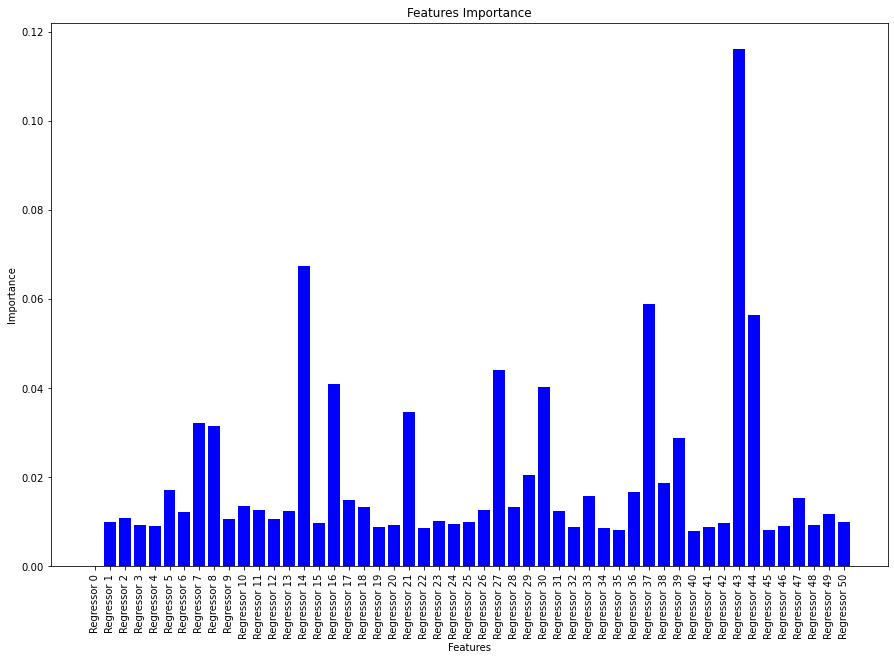

In [48]:
model = ensemble.RandomForestClassifier()
model.fit(x, y)
importance = model.feature_importances_

#for i,v in enumerate(importance):
    #print(f'Feature {i}: Score: {v*100}%')

plt.figure(figsize = (15,10))
plt.bar([f'Regressor {i}' for i in range(len(importance))], importance, color = 'blue')
plt.title('Features Importance')
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [53]:
len(importance[importance >= 0.02])

12

## Doc2Vec: 12 Regressors

In [55]:
model_12 = Doc2Vec(docs, vector_size=12, min_count=3)
model_12.save('Doc2Vec_12_Regressors')

In [59]:
model_12 = Doc2Vec.load('Doc2Vec_12_Regressors')

In [62]:
x = [model_12.infer_vector(all_cases[i]) for i in tqdm(range(len(all_cases)))]
x = np.array(x).reshape(-1, 12)
y = np.array([0 for i in range(neg_cases.shape[0])] + [1 for i in range(pos_cases.shape[0])])

In [63]:
model = ensemble.RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)

scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.895 (0.007)


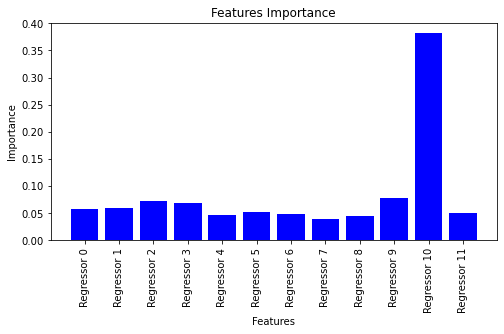

In [65]:
model = ensemble.RandomForestClassifier()
model.fit(x, y)
importance = model.feature_importances_

#for i,v in enumerate(importance):
    #print(f'Feature {i}: Score: {v*100}%')

plt.figure(figsize = (8,4))
plt.bar([f'Regressor {i}' for i in range(len(importance))], importance, color = 'blue')
plt.title('Features Importance')
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [66]:
model = LogisticRegression()
model.fit(x, y)

print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Intercept:  [-5.93187933]
Coefficient:  [[ 0.48545379  0.14525752 -0.59781551 -0.35620274 -1.06240419 -0.08810234
  -0.19276914 -0.35090975  1.22697903 -0.38720553  1.35505951  0.22687103]]
Mean Accuracy: 0.846 (0.008)


## Doc2Vec Comparisons

In [68]:
n_regressors = [i for i in range(2, 50)]
y = np.array([0 for i in range(neg_cases.shape[0])] + [1 for i in range(pos_cases.shape[0])])
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
accuracies = []

for i in tqdm(range(len(n_regressors))):
    n = n_regressors[i]
    model = Doc2Vec(docs, vector_size=n, min_count=3)
    model.save(f'Doc2Vec_{n}_Regressors')
    x = [model.infer_vector(all_cases[i]) for i in range(len(all_cases))]
    x = np.array(x).reshape(-1, n)
    model = ensemble.RandomForestClassifier()
    scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
    accuracies.append(np.mean(scores))
    
doc2vec_accuracies = pd.DataFrame()
doc2vec_accuracies['Number of Regressors'] = n_regressors
doc2vec_accuracies['Accuracy'] = accuracies
doc2vec_accuracies.to_csv('Doc2Vec_Accuracy.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 48/48 [11:32:45<00:00, 865.96s/it]


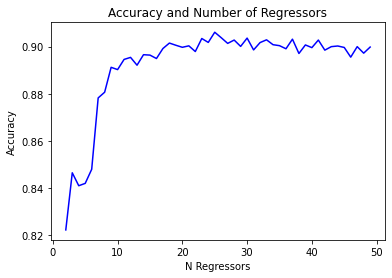

In [69]:
plt.plot(n_regressors, accuracies, color = 'blue')
plt.xlabel('N Regressors')
plt.ylabel('Accuracy')
plt.title('Accuracy and Number of Regressors')
plt.show()

In [72]:
doc2vec_accuracies.sort_values('Accuracy', ascending = False).head()

,Number of Regressors,Accuracy
23,25,0.906126
24,26,0.903807
28,30,0.903636
21,23,0.903461
35,37,0.903185


## Best Model Analysis

In [67]:
pos_cases = pd.read_csv('Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)

all_cases = list(neg_cases['Words']) + list(pos_cases['Words'])
all_cases = [all_cases[i].split(',') for i in range(len(all_cases))]

In [11]:
model = Doc2Vec.load('Brutality_25_Regressors')
doc_vectors = [model.infer_vector(all_cases[i]) for i in tqdm(range(len(all_cases)))]

100%|██████████████████████████████████████████████████████████████████████████████| 9630/9630 [07:13<00:00, 22.20it/s]


In [17]:
x = np.array(doc_vectors).reshape(-1, 25)
y = np.array([0 for i in range(neg_cases.shape[0])] + [1 for i in range(pos_cases.shape[0])])
model = ensemble.RandomForestClassifier()

In [35]:
n = 7
sample = len(x)//n
all_indexes = np.arange(len(y))

accuracies = []
false_positives = []
false_negatives = []

false_positive_indexes = np.zeros(shape = len(x))
false_negative_indexes = np.zeros(shape = len(x))

for i in tqdm(range(n)):
    test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
    train_indexes = [j for j in range(len(y)) if j not in test_indexes]
    train_x = x[train_indexes]
    test_x = x[test_indexes]
    
    train_y = y[train_indexes]
    test_y = y[test_indexes]
    
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    
    correct = 0
    false_positive = 0
    false_negative = 0
    
    for k in range(len(preds)):
        if test_y[k] == preds[k]:
            correct += 1
        elif test_y[k] == 0 and preds[k] == 1:
            false_positive += 1
            mid_index = test_indexes[k]
            false_positive_indexes[mid_index] = 1
        elif test_y[k] == 1 and preds[k] == 0:
            false_negative += 1
            mid_index = test_indexes[k]
            false_negative_indexes[mid_index] = 1
            
    accuracies.append(correct*100/sample)
    false_positives.append(false_positive*100/sample)
    false_negatives.append(false_negative*100/sample)
    
    all_indexes = list(all_indexes)
    for index in test_indexes:
        all_indexes.remove(index)
    all_indexes = np.array(all_indexes)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


AttributeError: 'Doc2Vec' object has no attribute 'fit'

In [37]:
print(f'Accuracy: {np.mean(accuracies)}%')
print(f'False Positive: {np.mean(false_positives)}%')
print(f'False Negative: {np.mean(false_negatives)}%')

Accuracy: 90.62857142857142%
False Positive: 3.9896103896103896%
False Negative: 5.381818181818182%


## File Generation

In [69]:
neg = pd.read_csv('Neg_Cases.csv').drop('Unnamed: 0', axis = 1)
pos = pd.read_csv('Pos_Cases.csv').drop('Unnamed: 0', axis = 1)
all_ = pd.concat([neg, pos])

original = pd.read_csv('All_Cases.csv').drop('Unnamed: 0', axis = 1)
original = original[original['Brutality Rule'].notnull()]
original = original.drop_duplicates('URL')

all_['False_Positive_Prediction'] = false_positive_indexes
all_['False_Negative_Prediction'] = false_negative_indexes

all_.head()

,Case Text,Labels,URL,False_Positive_Prediction,False_Negative_Prediction
0,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20140701173,0.0,0.0
1,"\n\n\nUnited States Court of Appeals, Eleventh...",0,https://www.leagle.com/decision/infco20131231066,0.0,0.0
2,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20121016226,0.0,0.0
3,"\n\n\n\n\n\n\nFlaum, Circuit Judge.\nThis is t...",0,https://www.leagle.com/decision/infco20190606173,0.0,0.0
4,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20150608101,0.0,0.0


In [70]:
complete = pd.merge(original, all_, on = 'URL').reset_index(drop = True)
print(complete.shape)
complete.head()

(9630, 59)


,URL,Fed Recorder,Appellees,Appellants,Other Parties,Court,Case Number,Original Decision Date,Second Original Decision Date,Third Original Decision Date,...,Count Frivolous,Frivolous,Immigration Rule,Brutality Rule,Error,Error Messages,Case Text,Labels,False_Positive_Prediction,False_Negative_Prediction
0,https://www.leagle.com/decision/20061317464f3d...,464 F.3d 853 (2006),"Stephen BURRELL, Plaintiff-Appellant,","Mike McILROY; Glen C. Rector; Jeff Thorpe, Def...",NaN,"United States Court of Appeals, Ninth Circuit",No. 02-15114.,NaN,NaN,NaN,...,0.0,[],0.0,1.0,0.0,[],"\n\n\nUnited States Court of Appeals, Ninth Ci...",1,0.0,0.0
1,https://www.leagle.com/decision/20051544423f3d...,423 F.3d 1121 (2005),"Stephen BURRELL, Plaintiff-Appellant,","Mike McILROY, Glen C. Rector, Jeff Thorpe, Def...",NaN,"United States Court of Appeals, Ninth Circuit",No. 02-15114.,NaN,NaN,NaN,...,0.0,[],0.0,1.0,0.0,[],"\n\n\nUnited States Court of Appeals, Ninth Ci...",1,0.0,0.0
2,https://www.leagle.com/decision/20051329423f3d...,423 F.3d 906 (2005),R.J. REYNOLDS TOBACCO COMPANY; Lorillard Tobac...,"Sandra SHEWRY, Director of the California Depa...",NaN,"United States Court of Appeals, Ninth Circuit",No. 03-16535.,NaN,NaN,NaN,...,0.0,[],0.0,0.0,0.0,[],"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,0.0,0.0
3,https://www.leagle.com/decision/20051094418f3d...,418 F.3d 676 (2005),"Clifford CUMMINGS, Jr., Plaintiff-Appellant,",CITY OF AKRON; Rodney Sherman; and Howard Vaug...,NaN,"United States Court of Appeals, Sixth Circuit",No. 03-3259.,NaN,NaN,NaN,...,0.0,[],0.0,1.0,0.0,[],"\n\n\nUnited States Court of Appeals, Sixth Ci...",1,0.0,0.0
4,https://www.leagle.com/decision/20051248412f3d...,412 F.3d 836 (2005),"Navreet NANDA, Plaintiff-Appellee,","Gerald MOSS, Defendant-Appellant.",NaN,"United States Court of Appeals, Seventh Circuit",No. 04-1641.,NaN,NaN,NaN,...,0.0,[],0.0,0.0,0.0,[],"\n\n\nUnited States Court of Appeals, Seventh ...",0,0.0,0.0


In [71]:
#complete.to_csv('Case_Predictions_ML.csv')

# Immigration

In [14]:
neg = pd.read_csv('Neg_Cases.csv').drop('Unnamed: 0', axis = 1)
pos = pd.read_csv('Pos_Cases.csv').drop('Unnamed: 0', axis = 1)
all_ = pd.concat([neg, pos])

original = pd.read_csv('All_Cases.csv').drop('Unnamed: 0', axis = 1)
original = original[original['Brutality Rule'].notnull()]
original = original.drop_duplicates('URL')

comp = pd.merge(all_, original, on = 'URL')
print(comp.shape)
comp.head()

(9630, 57)


,Case Text,Labels,URL,Fed Recorder,Appellees,Appellants,Other Parties,Court,Case Number,Original Decision Date,...,F.3d,Word Count,Publi Occurrences,Count Errata,Count Frivolous,Frivolous,Immigration Rule,Brutality Rule,Error,Error Messages
0,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20140701173,NaN,"SOUTH YUBA RIVER CITIZENS LEAGUE, a non-profit...",NATIONAL MARINE FISHERIES SERVICE; REBECCA M. ...,NaN,"United States Court of Appeals, Ninth Circuit",No. 12-16674.,NaN,...,0.0,272.0,[' NOT FOR PUBLICATION MEMORANDUM The governme...,0.0,0.0,[],0.0,0.0,0.0,[]
1,"\n\n\nUnited States Court of Appeals, Eleventh...",0,https://www.leagle.com/decision/infco20131231066,NaN,"JOSE MANUEL SILVA QUINTANILLA, Petitioner-Appe...","US IMMIGRATION AND CUSTOMS ENFORCEMENT (ICE), ...",NaN,"United States Court of Appeals, Eleventh Circuit",No. 13-11247.,NaN,...,0.0,171.0,[],0.0,0.0,[],0.0,0.0,0.0,[]
2,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20121016226,NaN,"UNITED STATES OF AMERICA, Plaintiff-Appellee,","ADRIAN ORTEGA-DIAZ, Defendant-Appellant.",NaN,"United States Court of Appeals, Ninth Circuit",No. 11-10486.,NaN,...,0.0,159.0,[' NOT FOR PUBLICATION MEMORANDUM Adrian Orteg...,0.0,0.0,[],0.0,0.0,0.0,[]
3,"\n\n\n\n\n\n\nFlaum, Circuit Judge.\nThis is t...",0,https://www.leagle.com/decision/infco20190606173,926 F.3d 377 (2019...,"Jessica SMITH, on behalf of Plaintiff and a cl...","SIMM ASSOCIATES, INC., Defendant-Appellee. Sim...",NaN,"United States Court of Appeals, Seventh Circuit","No. 18-3350, No. 19-1155.",NaN,...,1.0,1273.0,[],0.0,0.0,[],0.0,0.0,0.0,[]
4,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20150608101,NaN,"UNITED STATES OF AMERICA, Plaintiff-Appellee,","AUGUSTUS OHEMENG, M.D., Defendant-Appellant.",NaN,"United States Court of Appeals, Ninth Circuit",No. 13-50347.,NaN,...,0.0,679.0,[' NOT FOR PUBLICATION MEMORANDUM Augustus Ohe...,0.0,0.0,[],0.0,0.0,0.0,[]


In [15]:
print(comp[comp['Immigration Rule'] == 1].shape[0])
print(original[original['Immigration Rule'] == 1].shape[0])
print(comp[comp['Immigration Rule'] == 0].shape[0])

688
34383
8941


In [16]:
pos_imm = original[original['Immigration Rule'] == 1].reset_index(drop = True)
pos_imm_indexes = np.random.choice(np.arange(pos_imm.shape[0]), size = 10000, replace = False)
pos_imm_sub = pos_imm[pos_imm.index.isin(pos_imm_indexes)].reset_index(drop = True)
print(pos_imm_sub.shape)

(10000, 55)


In [20]:
pos_imm_cases = text_scraping(pos_imm_sub['URL'])

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:55:38<00:00,  1.44it/s]


In [23]:
neg_imm = original[(original['Immigration Rule'] == 0) & (~original['URL'].isin(comp['URL']))].reset_index(drop = True)
neg_imm_indexes = np.random.choice(np.arange(neg_imm.shape[0]), size = 2000, replace = False)
neg_imm_sub = neg_imm[neg_imm.index.isin(neg_imm_indexes)].reset_index(drop = True)
print(neg_imm_sub.shape)

neg_imm_cases = text_scraping(neg_imm_sub['URL'])

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

(2000, 55)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [26:27<00:00,  1.26it/s]


In [28]:
all_imm_cases = pd.DataFrame()
all_imm_cases['URL'] = list(pos_imm_sub['URL']) + list(neg_imm_sub['URL'])
all_imm_cases['Case Text'] = pos_imm_cases + neg_imm_cases
#all_imm_cases.to_csv('Immigration_Texts.csv')
all_imm_cases.head()

,URL,Case Text
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci..."
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ..."
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci..."
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C..."
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci..."


In [30]:
pos_imm_cases_processed = text_processing(pos_imm_cases)
neg_imm_cases_processed = text_processing(neg_imm_cases)
all_imm_cases_processed = pos_imm_cases_processed + neg_imm_cases_processed
all_imm_cases['Words'] = all_imm_cases_processed
all_imm_cases.to_csv('Immigration_Texts.csv')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:11:13<00:00,  2.14s/it]


In [51]:
all_imm_cases = pd.read_csv('Immigration_Texts.csv').drop('Unnamed: 0', axis = 1)
all_imm_cases['Words'] = all_imm_cases.apply(lambda x: x['Words'][1:-1], axis = 1)
all_imm_cases['Label'] = [1 for i in range(10000)] + [0 for i in range(2000)]
print(all_imm_cases.shape[0])
all_imm_cases.head()

12000


,URL,Case Text,Words,Label
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1


In [45]:
pos_cases = pd.read_csv('Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
processed_brut_cases = pd.concat([neg_cases, pos_cases])
print(processed_brut_cases.shape[0])
all_['Words'] = processed_brut_cases['Words']
all_.head()

9630


,Case Text,Labels,URL,Words
0,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20140701173,"united,state,court,appeal,ninth,circuit,public..."
1,"\n\n\nUnited States Court of Appeals, Eleventh...",0,https://www.leagle.com/decision/infco20131231066,"united,state,court,appeal,eleventh,circuit,pub..."
2,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20121016226,"united,state,court,appeal,ninth,circuit,public..."
3,"\n\n\n\n\n\n\nFlaum, Circuit Judge.\nThis is t...",0,https://www.leagle.com/decision/infco20190606173,"flaum,circuit,judge,consolidated,appeal,two,ac..."
4,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20150608101,"united,state,court,appeal,ninth,circuit,public..."


In [53]:
neg_imm_2 = all_[all_['URL'].isin(list(comp.loc[comp['Immigration Rule'] == 0, 'URL']))].drop('Labels', axis = 1)
neg_imm_2['Label'] = 0
all_imm_cases = pd.concat([all_imm_cases, neg_imm_2]).reset_index(drop = True)
all_imm_cases.head()

,URL,Case Text,Words,Label
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1


In [55]:
imm_cases = list(all_imm_cases.apply(lambda x: x['Words'].split(','), axis = 1))

docs = []
for i in tqdm(range(len(imm_cases))):
    docs.append(TaggedDocument(imm_cases[i], [i]))
    
model = Doc2Vec(docs, vector_size=25, min_count=3)
model.save('Immigration_25_Regressors')

100%|█████████████████████████████████████████████████████████████████████████| 20941/20941 [00:00<00:00, 25737.00it/s]


In [57]:
model = Doc2Vec.load('Immigration_25_Regressors')
imm_cases_vectors = [model.infer_vector(imm_cases[i]) for i in tqdm(range(len(imm_cases)))]
x = np.array(imm_cases_vectors).reshape(-1, 25)
y = np.array(all_imm_cases['Label'])

start = time.time()
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x,y)
print(np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives))
end = time.time()
print(f'Total time: {end-start} seconds')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:06<00:00, 43.86s/it]

97.64531690309023 0.5444906147012466 1.8101924822085305
Total time: 307.0258448123932 seconds


In [60]:
all_imm_cases['Immigration ML Prediction'] = predictions
#all_imm_cases.to_csv('Immigration_Predictions.csv')
print(all_imm_cases.shape)
all_imm_cases.head()

(20941, 5)


,URL,Case Text,Words,Label,Immigration ML Prediction
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,0.0
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0


In [68]:
all_imm_cases['False Positive'] = 0
all_imm_cases.loc[(all_imm_cases['Label'] == 0) & (all_imm_cases['Immigration ML Prediction'] == 1), 'False Positive'] = 1
all_imm_cases['False Negative'] = 0
all_imm_cases.loc[(all_imm_cases['Label'] == 1) & (all_imm_cases['Immigration ML Prediction'] == 0), 'False Negative'] = 1
#all_imm_cases.to_csv('Immigration_Predictions.csv')
all_imm_cases.head()

,URL,Case Text,Words,Label,Immigration ML Prediction,False Positive,False Negative
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0,0,0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0,0,0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0,0,0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,0.0,0,1
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0,0,0


# Civil Rights

In [11]:
os.listdir('CivilRights-Extracts')

['CivilRights-Apr2014-1.xlsx',
 'CivilRights-Apr2020-1-Miles.xlsx',
 'CivilRights-Concat-2.xlsx',
 'CivilRights-Concat-3.xlsx',
 'CivilRights-Concat.xlsx',
 'CivilRights-Dec2018-1.xlsx',
 'CivilRights-Feb2011-1-Jorgen.xlsx',
 'CivilRights-Feb2016-Francesco.xlsx',
 'CivilRights-Feb2017-Raymond.xlsx',
 'CivilRights-Jan2019-1-Francesco.xlsx',
 'CivilRights-July2012-Francesco.xlsx',
 'CivilRights-June2018.xlsx',
 'CivilRights-Mar2011-1-Raymond.xlsx',
 'CivilRights-March2012.xlsx',
 'CivilRights-March2018.xlsx',
 'CivilRights-Nov2018-1.xlsx',
 'CivilRights-Oct2018-1.xlsx',
 'CivilRights-Sept2007 - Jorgen.xlsx',
 'CivilRights-Sept2011_V3 - Miles.xlsx',
 'CivilRights-Sept2016-1.xlsx',
 'Race-Apr2018.xlsx',
 'Race-Mar2013.xlsx']

In [12]:
all_files = os.listdir('CivilRights-Extracts')
cvr = pd.DataFrame()

for i in tqdm(range(len(all_files))):
    file_directory = 'CivilRights-Extracts/' + all_files[i]
    cvr = pd.concat([cvr, pd.read_excel(file_directory)])
print(cvr.shape)
cvr.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:15<00:00,  3.43s/it]

(56009, 50)


,URL,Decision Date,Case Number,Personal Ruling,Notes,Civil Rights Case?,Count Title VII,Summary Count Title VII,Count 42 USC,Summary Count 42 USC,...,Appellees Names,Sure Plaintiffs Names,Sure Defendant Names,Petitioner Names,Respondent Names,Lean Name-Race Pairs,Lean Name-Race Flag,Lean Modified Nouns Pairs,Unnamed: 28,Contains Person-Race pair
0,https://www.leagle.com/decision/infco20180119105,"Argued and Submitted April 11, 2014 — Pasadena...",No. 12-55995.,,,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.leagle.com/decision/infco20170123101,"Argued April 2, 2014.",No. 13-2609.,,,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.leagle.com/decision/infco20170118148,"Submitted April 7, 2014.",No. 13-70520.,,,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.leagle.com/decision/infco20160802135,"Argued and Submitted April 7, 2014",No. 11-71458.,,,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.leagle.com/decision/infco20160721133,"Argued and Submitted April 8, 2014.",No. 12-30377.,,,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
cvr = cvr.drop_duplicates('URL').reset_index(drop = True)
print(cvr.shape)

(32531, 50)


In [14]:
cvr = cvr[(cvr['Personal Ruling'] == 0) | (cvr['Personal Ruling'] == 1)]
print(cvr.shape)

(1228, 50)


In [15]:
upd_1 = pd.read_excel('CivilRights-Extracts/CivilRights-Feb2016-Francesco.xlsx')
upd_2 = pd.read_excel('CivilRights-Extracts/CivilRights-Feb2017-Raymond.xlsx')
upd_3 = pd.read_excel('CivilRights-Extracts/Race-Apr2018.xlsx')
upd_4 = pd.read_excel('CivilRights-Extracts/Race-Mar2013.xlsx')
cvr_upd = pd.concat([upd_1, upd_2, upd_3, upd_4])
cvr_upd = cvr_upd.drop_duplicates('URL')
print(cvr_upd.shape)

(9301, 43)


In [16]:
cvr_final = pd.concat([cvr, cvr_upd]).drop_duplicates('URL').reset_index(drop = True)
print(cvr_final.shape)

(10295, 50)


In [17]:
labels = np.array(cvr_final.apply(lambda x: x['Personal Ruling'] if x['Personal Ruling'] != ' ' and str(x['Personal Ruling']) != 'nan' else x['Civil Rights Case?'], axis = 1))
cvr_final['Label'] = labels
labels

array([1, 1, 1, ..., 0.0, 0.0, 0.0], dtype=object)

In [20]:
neg_indexes = np.random.choice(cvr_final[cvr_final['Label'] == 0].index, size = 1200, replace = False)
cvr_final_neg = cvr_final[cvr_final.index.isin(neg_indexes)]
cvr_final_pos = cvr_final[cvr_final['Label'] == 1]
cvr_final = pd.concat([cvr_final_pos, cvr_final_neg]).reset_index(drop = True)
print(cvr_final.shape)

(2105, 51)


In [25]:
cvr_cases = text_scraping(cvr_final['URL'])
cvr_processed_cases = text_processing(cvr_cases)

100%|████████████████████████████████████████████████████████████████████████████| 2105/2105 [1:31:59<00:00,  2.62s/it]


In [31]:
cvr_processed_cases_new = [','.join(cvr_processed_cases[i]) for i in range(len(cvr_processed_cases))]
cvr_final['Words'] = cvr_processed_cases_new
#cvr_final.to_csv('Civil_Rights_Processed_Cases.csv')
cvr_final.head()

,URL,Decision Date,Case Number,Personal Ruling,Notes,Civil Rights Case?,Count Title VII,Summary Count Title VII,Count 42 USC,Summary Count 42 USC,...,Sure Defendant Names,Petitioner Names,Respondent Names,Lean Name-Race Pairs,Lean Name-Race Flag,Lean Modified Nouns Pairs,Unnamed: 28,Contains Person-Race pair,Label,Words
0,https://www.leagle.com/decision/infco20141125220,"Argued April 15, 2014.",No. 13-3735.,1,terminated allegedly because of disability,1.0,6.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"united,state,court,appeal,seventh,circuit,ripp..."
1,https://www.leagle.com/decision/infco20140815237,"Submitted: April 14, 2014.",No. 13-2646.,1,terminated allegedly because of disability,1.0,0.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"united,state,court,appeal,eighth,circuit,collo..."
2,https://www.leagle.com/decision/infco20140801155,"Argued April 8, 2014.",No. 12-5345.,1,non-promotion allegedly racially discriminatory,1.0,4.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"united,state,court,appeal,district,columbia,ci..."
3,https://www.leagle.com/decision/infco20140724148,"Argued and Submitted April 9, 2014 — San Franc...",No. 12-15998.,1,"several claims, including race discrimination,...",1.0,10.0,5.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"united,state,court,appeal,ninth,circuit,public..."
4,https://www.leagle.com/decision/infco20140710063,"Argued: April 10, 2014.",No. 13-2694-PR.,1,"religious discrimination, require urine sample...",1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"united,state,court,appeal,second,circuit,debra..."


In [33]:
cvr_cases = cvr_final.apply(lambda x: x['Words'].split(','), axis = 1)

docs = []
for i in tqdm(range(len(cvr_cases))):
    docs.append(TaggedDocument(cvr_cases[i], [i]))
    
model = Doc2Vec(docs, vector_size=25, min_count=3)
model.save('Civil_Rights_25_Regressors')

100%|███████████████████████████████████████████████████████████████████████████| 2105/2105 [00:00<00:00, 11194.00it/s]


In [41]:
model = Doc2Vec.load('Civil_Rights_25_Regressors')
cvr_cases_vectors = [model.infer_vector(cvr_cases[i]) for i in tqdm(range(len(cvr_cases)))]

100%|██████████████████████████████████████████████████████████████████████████████| 2105/2105 [01:18<00:00, 26.91it/s]


In [40]:
x = np.array(cvr_cases_vectors).reshape(-1, 25)
y = np.array(cvr_final['Label'])
y = y.astype('int32')

start = time.time()
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x,y)
print(np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives))
end = time.time()
print(f'Total time: {end-start} seconds')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.69s/it]

85.71428571428571 5.428571428571429 8.857142857142858
Total time: 18.852940320968628 seconds


In [46]:
cvr_predictions = pd.DataFrame()
cvr_predictions['URL'] = cvr_final['URL']
cvr_predictions['Words'] = cvr_final['Words']
cvr_predictions['Label'] = cvr_final['Label']
cvr_predictions['CV ML Prediction'] = predictions
cvr_predictions.head()

,URL,Words,Label,CV ML Prediction
0,https://www.leagle.com/decision/infco20141125220,"united,state,court,appeal,seventh,circuit,ripp...",1,1.0
1,https://www.leagle.com/decision/infco20140815237,"united,state,court,appeal,eighth,circuit,collo...",1,1.0
2,https://www.leagle.com/decision/infco20140801155,"united,state,court,appeal,district,columbia,ci...",1,1.0
3,https://www.leagle.com/decision/infco20140724148,"united,state,court,appeal,ninth,circuit,public...",1,1.0
4,https://www.leagle.com/decision/infco20140710063,"united,state,court,appeal,second,circuit,debra...",1,0.0


In [49]:
cvr_predictions['False Positive'] = 0
cvr_predictions.loc[(cvr_predictions['Label'] == 0) & (cvr_predictions['CV ML Prediction'] == 1), 'False Positive'] = 1
cvr_predictions['False Negative'] = 0
cvr_predictions.loc[(cvr_predictions['Label'] == 1) & (cvr_predictions['CV ML Prediction'] == 0), 'False Negative'] = 1
cvr_predictions.head()

,URL,Words,Label,CV ML Prediction,False Positive,False Negative
0,https://www.leagle.com/decision/infco20141125220,"united,state,court,appeal,seventh,circuit,ripp...",1,1.0,0,0
1,https://www.leagle.com/decision/infco20140815237,"united,state,court,appeal,eighth,circuit,collo...",1,1.0,0,0
2,https://www.leagle.com/decision/infco20140801155,"united,state,court,appeal,district,columbia,ci...",1,1.0,0,0
3,https://www.leagle.com/decision/infco20140724148,"united,state,court,appeal,ninth,circuit,public...",1,1.0,0,0
4,https://www.leagle.com/decision/infco20140710063,"united,state,court,appeal,second,circuit,debra...",1,0.0,0,1


In [50]:
#cvr_predictions.to_csv('Civil_Rights_Predictions.csv')

In [43]:
n_regressors = [i for i in range(2, 30)]
y = np.array(cvr_final['Label']).astype('int32')
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=2)
accuracies = []

for i in tqdm(range(len(n_regressors))):
    n = n_regressors[i]
    model = Doc2Vec(docs, vector_size=n, min_count=3)
    x = [model.infer_vector(cvr_cases[i]) for i in range(len(cvr_cases))]
    x = np.array(x).reshape(-1, n)
    model = ensemble.RandomForestClassifier()
    scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
    accuracies.append(np.mean(scores))
    
doc2vec_accuracies = pd.DataFrame()
doc2vec_accuracies['Number of Regressors'] = n_regressors
doc2vec_accuracies['Accuracy'] = accuracies
#doc2vec_accuracies.to_csv('Civil_Rights_Accuracies.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [1:06:09<00:00, 141.76s/it]


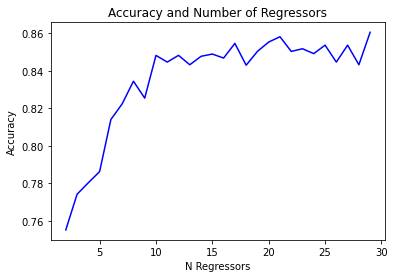

In [44]:
plt.plot(n_regressors, accuracies, color = 'blue')
plt.xlabel('N Regressors')
plt.ylabel('Accuracy')
plt.title('Accuracy and Number of Regressors')
plt.show() 

## Different Weights

### Police Brutality

In [52]:
model = Doc2Vec.load('Brutality_25_Regressors')

pos_cases = pd.read_csv('Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
all_cases = list(neg_cases['Words']) + list(pos_cases['Words'])
all_cases = [all_cases[i].split(',') for i in range(len(all_cases))]

doc_vectors = [model.infer_vector(all_cases[i]) for i in tqdm(range(len(all_cases)))]

100%|██████████████████████████████████████████████████████████████████████████████| 9630/9630 [10:34<00:00, 15.18it/s]


In [59]:
x = np.array(doc_vectors).reshape(-1, 25)
y = np.array([0 for i in range(neg_cases.shape[0])] + [1 for i in range(pos_cases.shape[0])])
weights = [0.7, 0.3]
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x, y, model = ensemble.RandomForestClassifier(class_weight = {0:weights[0], 1:weights[1]}))
print(np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:58<00:00, 16.90s/it]

90.03636363636363 4.571428571428571 5.392207792207793


In [60]:
#Weights Comparison

all_weights = [0.5, 0.6, 0.7, 0.8, 0.9]
all_false_positives = []
all_accuracies = []

for i in range(len(all_weights)):
    accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x, y, model = ensemble.RandomForestClassifier(class_weight = {0:all_weights[i], 1:1-all_weights[i]}))
    all_accuracies.append(np.mean(accuracies))
    all_false_positives.append(np.mean(false_positives))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:41<00:00, 23.03s/it]

[[4.290909090909091, 3.1272727272727274, 4.1454545454545455, 4.218181818181818, 3.6363636363636362, 4.4363636363636365, 4.8], [3.3454545454545452, 4.581818181818182, 3.8545454545454545, 5.163636363636364, 4.363636363636363, 4.218181818181818, 4.945454545454545], [4.072727272727272, 5.0181818181818185, 4.945454545454545, 4.945454545454545, 4.509090909090909, 5.236363636363636, 4.4363636363636365], [5.236363636363636, 5.090909090909091, 5.527272727272727, 5.454545454545454, 5.0181818181818185, 5.090909090909091, 5.3090909090909095], [6.4, 5.236363636363636, 5.454545454545454, 5.672727272727273, 5.672727272727273, 6.254545454545455, 4.945454545454545]]


In [67]:
print(all_accuracies)
print(all_false_positives)

[89.9948051948052, 90.20259740259742, 89.79740259740258, 89.42337662337661, 89.16363636363636]
[4.093506493506494, 4.353246753246753, 4.7376623376623375, 5.246753246753246, 5.662337662337662]


In [64]:
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x, y, model = ensemble.RandomForestClassifier(class_weight = {0:0.95, 1:0.05}))
print(np.mean(accuracies))
print(np.mean(false_positives))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:24<00:00, 20.58s/it]

88.65454545454547
6.264935064935066


In [79]:
def false_2(predictions):
    false_2_positive = len(predictions[(predictions == 1) & (y == 0)])/len(predictions[predictions == 1])
    false_2_negative = len(predictions[(predictions == 0) & (y == 1)])/len(predictions[predictions == 0])
    positive_predictions = predictions[predictions == 1].sum()
    return false_2_positive, false_2_negative, positive_predictions

In [75]:
false_2(predictions)

(0.14006968641114984, 0.09220657276995305)

In [77]:
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x, y, model = ensemble.RandomForestClassifier(class_weight = {0:0.99, 1:0.01}))
print(np.mean(accuracies))
print(np.mean(false_positives))
false_2(predictions)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 25.90s/it]

88.2077922077922
6.8779220779220775


(0.1511760675953414, 0.09064940011426395)

In [80]:
neg = pd.read_csv('Neg_Cases.csv').drop('Unnamed: 0', axis = 1)
pos = pd.read_csv('Pos_Cases.csv').drop('Unnamed: 0', axis = 1)
all_ = pd.concat([neg, pos])
print(all_.shape)
all_.head()

(9630, 3)


,Case Text,Labels,URL
0,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20140701173
1,"\n\n\nUnited States Court of Appeals, Eleventh...",0,https://www.leagle.com/decision/infco20131231066
2,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20121016226
3,"\n\n\n\n\n\n\nFlaum, Circuit Judge.\nThis is t...",0,https://www.leagle.com/decision/infco20190606173
4,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20150608101


In [99]:
all_['Brutality_Weighted_Prediction'] = predictions
all_['False Positive'] = 0
all_.loc[(all_['Label'] == 0) & (all_['Brutality_Weighted_Prediction'] == 1), 'False Positive'] = 1
all_['False Negative'] = 0
all_.loc[(all_['Label'] == 1) & (all_['Brutality_Weighted_Prediction'] == 0), 'False Negative'] = 1
all_.to_csv('Brutality_Weighted_Predictions.csv')
all_.head()

,URL,Case Text,Words,Label,Immigration_Weighted_Prediction_1,False Positive,False Negative
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0,0,0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0,0,0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0,0,0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,1.0,0,0
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0,0,0


### Immigration

In [83]:
imm = pd.read_csv('Immigration_Predictions.csv').drop('Unnamed: 0', axis = 1)
imm.head()

,URL,Case Text,Words,Label,Immigration ML Prediction,False Positive,False Negative
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0,0,0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0,0,0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0,0,0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,0.0,0,1
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0,0,0


In [84]:
imm_cases = imm.apply(lambda x: x['Words'].split(','), axis = 1)
model = Doc2Vec.load('Immigration_25_Regressors')
imm_vectors = np.array([model.infer_vector(imm_cases[i]) for i in range(len(imm_cases))])

In [86]:
x = imm_vectors.reshape(-1, 25)
y = np.array(imm['Label'])
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x, y, model = ensemble.RandomForestClassifier(class_weight = {0:0.99, 1:0.01}))
print(np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives))
false_2(predictions)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:53<00:00, 41.91s/it]

97.55934470076897 0.9265892916845776 1.5140660075464487


(0.019645569620253163, 0.02882703777335984)

In [88]:
print(predictions[(predictions == 1) & (y == 0)].sum())

194.0


In [97]:
imm_new = imm[['URL', 'Case Text', 'Words', 'Label']]
imm_new['Immigration_Weighted_Prediction_1'] = predictions
imm_new['False Positive'] = 0
imm_new.loc[(imm_new['Label'] == 0) & (imm_new['Immigration_Weighted_Prediction_1'] == 1), 'False Positive'] = 1
imm_new['False Negative'] = 0
imm_new.loc[(imm_new['Label'] == 1) & (imm_new['Immigration_Weighted_Prediction_1'] == 0), 'False Negative'] = 1
#imm_new.to_csv('Immigration_Weighted_Predictions.csv')
imm_new.head()

,URL,Case Text,Words,Label,Immigration_Weighted_Prediction_1,False Positive,False Negative
0,https://www.leagle.com/decision/2005675427f3d2...,"\n\n\nUnited States Court of Appeals, Third Ci...","'united', 'state', 'court', 'appeal', 'third',...",1,1.0,0,0
1,https://www.leagle.com/decision/20051476425f3d...,"\n\n\nUnited States Court of Appeals, Seventh ...","'united', 'state', 'court', 'appeal', 'seventh...",1,1.0,0,0
2,https://www.leagle.com/decision/2005444400f3d4...,"\n\n\nUnited States Court of Appeals, First Ci...","'united', 'state', 'court', 'appeal', 'first',...",1,1.0,0,0
3,https://www.leagle.com/decision/2005916395f3d5...,"\n\n\nUnited States Court of Appeals, Fourth C...","'united', 'state', 'court', 'appeal', 'fourth'...",1,1.0,0,0
4,https://www.leagle.com/decision/20051092393f3d...,"\n\n\nUnited States Court of Appeals, Sixth Ci...","'united', 'state', 'court', 'appeal', 'sixth',...",1,1.0,0,0


### Civil Rights

In [100]:
cvr = pd.read_csv('Civil_Rights_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
cvr.head()

,URL,Decision Date,Case Number,Personal Ruling,Notes,Civil Rights Case?,Count Title VII,Summary Count Title VII,Count 42 USC,Summary Count 42 USC,...,Sure Defendant Names,Petitioner Names,Respondent Names,Lean Name-Race Pairs,Lean Name-Race Flag,Lean Modified Nouns Pairs,Unnamed: 28,Contains Person-Race pair,Label,Words
0,https://www.leagle.com/decision/infco20141125220,"Argued April 15, 2014.",No. 13-3735.,1,terminated allegedly because of disability,1.0,6.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"united,state,court,appeal,seventh,circuit,ripp..."
1,https://www.leagle.com/decision/infco20140815237,"Submitted: April 14, 2014.",No. 13-2646.,1,terminated allegedly because of disability,1.0,0.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"united,state,court,appeal,eighth,circuit,collo..."
2,https://www.leagle.com/decision/infco20140801155,"Argued April 8, 2014.",No. 12-5345.,1,non-promotion allegedly racially discriminatory,1.0,4.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"united,state,court,appeal,district,columbia,ci..."
3,https://www.leagle.com/decision/infco20140724148,"Argued and Submitted April 9, 2014 — San Franc...",No. 12-15998.,1,"several claims, including race discrimination,...",1.0,10.0,5.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"united,state,court,appeal,ninth,circuit,public..."
4,https://www.leagle.com/decision/infco20140710063,"Argued: April 10, 2014.",No. 13-2694-PR.,1,"religious discrimination, require urine sample...",1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"united,state,court,appeal,second,circuit,debra..."


In [102]:
upd_1 = pd.read_excel('CivilRights-Extracts/CivilRights-Feb2016-Francesco.xlsx')
upd_2 = pd.read_excel('CivilRights-Extracts/CivilRights-Feb2017-Raymond.xlsx')
upd_3 = pd.read_excel('CivilRights-Extracts/Race-Apr2018.xlsx')
upd_4 = pd.read_excel('CivilRights-Extracts/Race-Mar2013.xlsx')
cvr_upd = pd.concat([upd_1, upd_2, upd_3, upd_4])
cvr_upd = cvr_upd.drop_duplicates('URL')

cvr[cvr['URL'].isin(cvr_upd['URL'])].shape

(1452, 52)

## Final Files Generation

### Police Brutality

In [61]:
neg = pd.read_csv('Neg_Cases.csv').drop('Unnamed: 0', axis = 1)
pos = pd.read_csv('Pos_Cases.csv').drop('Unnamed: 0', axis = 1)
all_ = pd.concat([neg, pos])
print(all_.shape)
all_.head()

(9630, 3)


,Case Text,Labels,URL
0,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20140701173
1,"\n\n\nUnited States Court of Appeals, Eleventh...",0,https://www.leagle.com/decision/infco20131231066
2,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20121016226
3,"\n\n\n\n\n\n\nFlaum, Circuit Judge.\nThis is t...",0,https://www.leagle.com/decision/infco20190606173
4,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20150608101


In [13]:
original = pd.read_csv('All_Cases.csv').drop('Unnamed: 0', axis = 1)
original = original[original['Brutality Rule'].notnull()]
original = original.drop_duplicates('URL')
print(original.shape)
original.head()

(284181, 55)


,URL,Fed Recorder,Appellees,Appellants,Other Parties,Court,Case Number,Original Decision Date,Second Original Decision Date,Third Original Decision Date,...,F.3d,Word Count,Publi Occurrences,Count Errata,Count Frivolous,Frivolous,Immigration Rule,Brutality Rule,Error,Error Messages
5253,https://www.leagle.com/decision/infco20161108094,NaN,"UNITED States of America, Appellee,","ANTHONY BRUNO, ANGELO CERASULO, JOHN IMBRIECO,...",NaN,"United States Court of Appeals, Second Circuit","Docket Nos. 16-3384(L), 16-3386(CON), 03-1349(...",NaN,NaN,NaN,...,0.0,54.0,[],0.0,0.0,[],0.0,0.0,0.0,[]
5254,https://www.leagle.com/decision/2007618480f3d1...,480 F.3d 138 (2007),"D.D., a minor, by and through his Parent and N...",NEW YORK CITY BOARD OF EDUCATION; New York Cit...,NaN,"United States Court of Appeals, Second Circuit",Docket No. 04-2542-CV.,NaN,NaN,NaN,...,1.0,46.0,[],0.0,0.0,[],0.0,0.0,0.0,[]
5255,https://www.leagle.com/decision/2006968465cf3d...,465 F.3d 503 (2006),"D.D., a minor, by and through his Parent and N...",NEW YORK CITY BOARD OF EDUCATION; New York Cit...,NaN,"United States Court of Appeals, Second Circuit",Docket No. 04-2542-CV.,NaN,NaN,NaN,...,1.0,3903.0,['. The Secretary of Education subsequently pu...,0.0,0.0,[],0.0,0.0,0.0,[]
5256,https://www.leagle.com/decision/2006761464f3d2...,464 F.3d 297 (2006),"CITY OF SYRACUSE, Syracuse Urban Renewal Agenc...",ONONDAGA COUNTY and Onondaga County Department...,NaN,"United States Court of Appeals, Second Circuit",Docket No. 04-0718-cv.,NaN,NaN,NaN,...,1.0,10391.0,[' SURA voted to approve a Redevelopers Statem...,0.0,0.0,[],0.0,0.0,0.0,[]
5257,https://www.leagle.com/decision/20061317464f3d...,464 F.3d 853 (2006),"Stephen BURRELL, Plaintiff-Appellant,","Mike McILROY; Glen C. Rector; Jeff Thorpe, Def...",NaN,"United States Court of Appeals, Ninth Circuit",No. 02-15114.,NaN,NaN,NaN,...,1.0,3041.0,['. ORDER The opinion and dissent filed on Sep...,0.0,0.0,[],0.0,1.0,0.0,[]


In [26]:
pos_cases = pd.read_csv('Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
all_cases = list(neg_cases['Words']) + list(pos_cases['Words'])
all_cases = [all_cases[i].split(',') for i in range(len(all_cases))]

docs = []
for i in tqdm(range(len(all_cases))):
    docs.append(TaggedDocument(all_cases[i], [i]))
    
model = Doc2Vec(docs, vector_size=25, min_count=3)
model.save('Brutality_25_Regressors')

100%|████████████████████████████████████████████████████████████████████████████| 9630/9630 [00:04<00:00, 2112.09it/s]


In [57]:
def predictions_decomposition(x, y, model = ensemble.RandomForestClassifier(), n = 7):
    sample = len(x)//n
    all_indexes = np.arange(len(y))

    accuracies = []
    false_positives = []
    false_negatives = []
    
    false_positive_indexes = np.zeros(shape = len(x))
    false_negative_indexes = np.zeros(shape = len(x))
    predictions = np.zeros(shape = len(x))

    for i in tqdm(range(n)):
        test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
        train_indexes = [j for j in range(len(y)) if j not in test_indexes]
        train_x = x[train_indexes]
        test_x = x[test_indexes]

        train_y = y[train_indexes]
        test_y = y[test_indexes]
        
        model.fit(train_x, train_y)
        preds = model.predict(test_x)
        
        correct = 0
        false_positive = 0
        false_negative = 0

        for k in range(len(preds)):
            mid_index = test_indexes[k]
            predictions[mid_index] = preds[k]
            if test_y[k] == preds[k]:
                correct += 1
            elif test_y[k] == 0 and preds[k] == 1:
                false_positive += 1
                false_positive_indexes[mid_index] = 1
            elif test_y[k] == 1 and preds[k] == 0:
                false_negative += 1
                false_negative_indexes[mid_index] = 1

        accuracies.append(correct*100/sample)
        false_positives.append(false_positive*100/sample)
        false_negatives.append(false_negative*100/sample)

        all_indexes = list(all_indexes)
        for index in test_indexes:
            all_indexes.remove(index)
        all_indexes = np.array(all_indexes)
        
    return accuracies, false_positives, false_negatives, predictions

In [64]:
model = Doc2Vec.load('Brutality_25_Regressors')

pos_cases = pd.read_csv('Positive_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
neg_cases = pd.read_csv('Negative_Processed_Cases.csv').drop('Unnamed: 0', axis = 1)
all_cases = list(neg_cases['Words']) + list(pos_cases['Words'])
all_cases = [all_cases[i].split(',') for i in range(len(all_cases))]

doc_vectors = [model.infer_vector(all_cases[i]) for i in tqdm(range(len(all_cases)))]

100%|██████████████████████████████████████████████████████████████████████████████| 9630/9630 [10:20<00:00, 15.53it/s]


In [65]:
x = np.array(doc_vectors).reshape(-1, 25)
y = np.array(all_['Labels'])
accuracies, false_positives, false_negatives, predictions = predictions_decomposition(x,y)
print(np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:05<00:00, 26.56s/it]

90.23376623376625 4.041558441558442 5.724675324675325


In [71]:
all_['Brutality ML Prediction'] = predictions
all_['False Positive'] = 0
all_.loc[(all_['Labels'] == 0) & (all_['Brutality ML Prediction'] == 1), 'False Positive'] = 1
all_['False Negative'] = 0
all_.loc[(all_['Labels'] == 1) & (all_['Brutality ML Prediction'] == 0), 'False Negative'] = 1
#all_.to_csv('Brutality_Predictions.csv')
all_.head()

,Case Text,Labels,URL,Brutality ML Prediction,False Positive,False Negative
0,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20140701173,0.0,0,0
1,"\n\n\nUnited States Court of Appeals, Eleventh...",0,https://www.leagle.com/decision/infco20131231066,0.0,0,0
2,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20121016226,0.0,0,0
3,"\n\n\n\n\n\n\nFlaum, Circuit Judge.\nThis is t...",0,https://www.leagle.com/decision/infco20190606173,0.0,0,0
4,"\n\n\nUnited States Court of Appeals, Ninth Ci...",0,https://www.leagle.com/decision/infco20150608101,0.0,0,0


## Tf-Idf Method

In [68]:
all_cases = list(neg_cases['Words']) + list(pos_cases['Words'])
all_cases = [' '.join(all_cases[i].split(',')) for i in range(len(all_cases))]

In [69]:
#Tf-idf method
y_1 = [1 for i in range(pos_cases.shape[0])]
y_2 = [0 for i in range(neg_cases.shape[0])]
y = y_1 + y_2

vectorizer = CountVectorizer(max_features=750, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_cases).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
model = ensemble.RandomForestClassifier()
scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
print(np.mean(scores))

0.8434418101278565


## Similarity Score

In [107]:
def cosine_sim(x, y):
    num = (x*y).sum()
    den = np.sqrt(((x**2).sum())*((y**2).sum()))
    return num/den

In [73]:
model = Doc2Vec.load('Doc2Vec_25_Regressors')

In [78]:
doc_vectors = [model.infer_vector(all_cases[i]) for i in tqdm(range(len(all_cases)))]

100%|██████████████████████████████████████████████████████████████████████████████| 9630/9630 [07:42<00:00, 20.83it/s]


In [103]:
police_brutality = model.infer_vector(['police', 'brutality', 'discrimination', 'black', 'abuse'])

In [104]:
sims = [cosine_sim(police_brutality, doc_vectors[i]) for i in range(len(all_cases))]
neg_sims = sims[:neg_cases.shape[0]]
pos_sims = sims[neg_cases.shape[0]:]

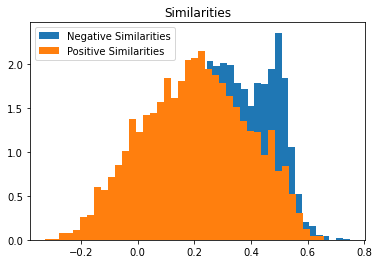

In [105]:
plt.hist(neg_sims, bins = 40, label = 'Negative Similarities', density = True)
plt.hist(pos_sims, bins = 40, label = 'Positive Similarities', density = True)
plt.legend()
plt.title('Similarities')
plt.show()

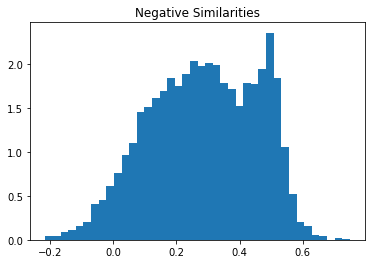

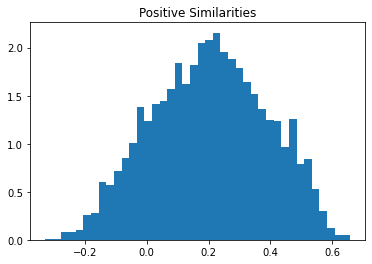

In [106]:
plt.hist(neg_sims, bins = 40, density = True)
plt.title('Negative Similarities')
plt.show()
plt.hist(pos_sims, bins = 40, density = True)
plt.title('Positive Similarities')
plt.show()

# Racial Disagreement

## Training Set Generation

In [11]:
disagreements = pd.read_csv('disagreement_cases.csv')
print(disagreements.shape)
disagreements.head()

(3107, 5)


,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement
0,1,No. 02-9007.,https://www.leagle.com/decision/2004458362f3d9...,1,0
1,1,No. 03-1307.,https://www.leagle.com/decision/2004416377f3d3...,0,1
2,1,No. 03-1453.,https://www.leagle.com/decision/2004585370f3d2...,1,1
3,1,No. 03-1678.,https://www.leagle.com/decision/2004383361f3d2...,1,0
4,1,No. 03-1795.,https://www.leagle.com/decision/2007542480f3d6...,0,1


In [21]:
cases_text = text_scraping(list(disagreements['s_URL']))

100%|██████████████████████████████████████████████████████████████████████████████| 3107/3107 [38:35<00:00,  1.34it/s]


In [22]:
null_indexes = []

for i in range(len(cases_text)):
    if cases_text[i] is None:
        null_indexes.append(i)

cases_text = list(cases_text)
while None in cases_text:
    cases_text.remove(None)
    
for i in range(len(cases_text)):
    if cases_text[i] is None:
        print(i)

In [23]:
print(null_indexes)

[166, 305, 361, 385, 588, 889, 893, 970, 1053, 1073, 1074, 1165, 1300, 1307, 1527, 1542, 1551, 1847, 1892, 1900, 1904, 1932, 1986, 1991, 2008, 2506, 2537, 2539, 2642, 2647, 2653, 2679, 2719, 2725, 2910]


In [24]:
cases_text_processed = text_processing(cases_text)
cases_text_processed = [','.join(cases_text_processed[i]) for i in range(len(cases_text_processed))]

100%|████████████████████████████████████████████████████████████████████████████| 3072/3072 [6:23:14<00:00,  7.49s/it]


In [26]:
disagreement_processed = pd.DataFrame()
disagreement_processed['Processed Case'] = cases_text_processed
disagreement_processed.to_csv('Disagreements_Processed.csv')

In [27]:
disagreements = disagreements[~disagreements.index.isin(null_indexes)]
disagreements['Words'] = cases_text_processed
disagreements.to_csv('Disagreements_Processed_Complete.csv')

In [33]:
disagreements.head()

,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement,Words
0,1,No. 02-9007.,https://www.leagle.com/decision/2004458362f3d9...,1,0,"united,state,court,appeal,first,circuit,cyr,se..."
1,1,No. 03-1307.,https://www.leagle.com/decision/2004416377f3d3...,0,1,"united,state,court,appeal,first,circuit,boudin..."
2,1,No. 03-1453.,https://www.leagle.com/decision/2004585370f3d2...,1,1,"united,state,court,appeal,first,circuit,torrue..."
3,1,No. 03-1678.,https://www.leagle.com/decision/2004383361f3d2...,1,0,"united,state,court,appeal,first,circuit,stahl,..."
4,1,No. 03-1795.,https://www.leagle.com/decision/2007542480f3d6...,0,1,"united,state,court,appeal,first,circuit,lynch,..."


### Remaining Cases

In [38]:
disagreements_original = pd.read_csv('disagreement_cases.csv')
disagreements_left = disagreements_original[disagreements_original.index.isin(null_indexes)]
print(disagreements_left.shape)
disagreements_left.head()

(35, 5)


,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement
166,2,"Docket Nos. 09-3760-cv(L), 09-3941-cv(CON).",https://www.leagle.com/decision/infco20100713088,1,1
305,3,No. 11-1398.,https://www.leagle.com/decision/infco20120522118,1,1
361,4,No. 02-1494.,https://www.leagle.com/decision/2004716387f3d3...,1,0
385,4,No. 04-1101.,https://www.leagle.com/decision/2005591403f3d1...,0,1
588,4,"Nos. 06-1285, 06-1491.",https://www.leagle.com/decision/2007728488f3d2...,1,0


In [47]:
cases_text_left = text_scraping(list(disagreements_left['s_URL']))

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:21<00:00,  1.61it/s]


In [48]:
null_indexes_left = []

for i in range(len(cases_text_left)):
    if cases_text_left[i] is None:
        null_indexes_left.append(i)
        
print(null_indexes_left)

[6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33]


## SR Disagreement

In [8]:
disagreements = pd.read_csv('Disagreements_Processed_Complete.csv').drop('Unnamed: 0', axis = 1)
disagreements.head()

,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement,Words
0,1,No. 02-9007.,https://www.leagle.com/decision/2004458362f3d9...,1,0,"united,state,court,appeal,first,circuit,cyr,se..."
1,1,No. 03-1307.,https://www.leagle.com/decision/2004416377f3d3...,0,1,"united,state,court,appeal,first,circuit,boudin..."
2,1,No. 03-1453.,https://www.leagle.com/decision/2004585370f3d2...,1,1,"united,state,court,appeal,first,circuit,torrue..."
3,1,No. 03-1678.,https://www.leagle.com/decision/2004383361f3d2...,1,0,"united,state,court,appeal,first,circuit,stahl,..."
4,1,No. 03-1795.,https://www.leagle.com/decision/2007542480f3d6...,0,1,"united,state,court,appeal,first,circuit,lynch,..."


In [51]:
all_disagreements = list(disagreements['Words'])
all_disagreements = [all_disagreements[i].split(',') for i in range(len(all_disagreements))]

docs = []
for i in tqdm(range(len(all_disagreements))):
    docs.append(TaggedDocument(all_disagreements[i], [i]))
    
model = Doc2Vec(docs, vector_size=10, min_count=3)

100%|████████████████████████████████████████████████████████████████████████████| 3072/3072 [00:00<00:00, 6749.86it/s]


In [52]:
model.save('Disagreements_10_Regressors')

In [58]:
model = Doc2Vec.load('Disagreements_10_Regressors')
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
x = [model.infer_vector(all_disagreements[i]) for i in tqdm(range(len(all_disagreements)))]
x = np.array(x).reshape(-1, 10)
y = list(disagreements['sr_disagreement'])
model = ensemble.RandomForestClassifier()
scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
print(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████| 3072/3072 [05:24<00:00,  9.46it/s]


0.7247188033845131


In [64]:
n_regressors = [i for i in range(2, 30)]
y = list(disagreements['sr_disagreement'])
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
accuracies = []

for i in tqdm(range(len(n_regressors))):
    n = n_regressors[i]
    model = Doc2Vec(docs, vector_size=n, min_count=3)
    model.save(f'Doc2Vec_{n}_Regressors')
    x = [model.infer_vector(all_disagreements[i]) for i in range(len(all_disagreements))]
    x = np.array(x).reshape(-1, n)
    model = ensemble.RandomForestClassifier()
    scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
    accuracies.append(np.mean(scores))
    
doc2vec_accuracies = pd.DataFrame()
doc2vec_accuracies['Number of Regressors'] = n_regressors
doc2vec_accuracies['Accuracy'] = accuracies
doc2vec_accuracies.to_csv('Doc2Vec_Accuracy.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [4:46:46<00:00, 614.52s/it]


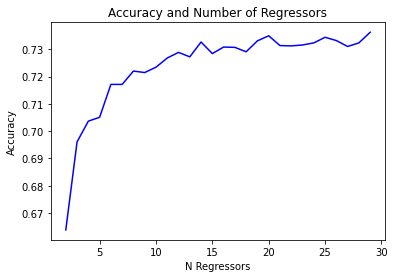

In [65]:
plt.plot(n_regressors, accuracies, color = 'blue')
plt.xlabel('N Regressors')
plt.ylabel('Accuracy')
plt.title('Accuracy and Number of Regressors')
plt.show()

### 20 Regressors

In [85]:
#model = Doc2Vec.load('Doc2Vec_20_Regressors')

#With SVSSMOTE
model = Doc2Vec(docs, vector_size=20, min_count=3)
x = [model.infer_vector(all_disagreements[i]) for i in tqdm(range(len(all_disagreements)))]
x = np.array(x).reshape(-1, 20)
y = list(disagreements['sr_disagreement'])
model = ensemble.RandomForestClassifier()
over_model = SVMSMOTE()
steps = [('over', over_model), ('model', model)]
pipeline = Pipeline(steps=steps)
scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv)
print(np.mean(scores))

100%|██████████████████████████████████████████████████████████████████████████████| 3072/3072 [05:38<00:00,  9.08it/s]


0.6921701310723685


In [86]:
#No SMOTE

model = ensemble.RandomForestClassifier()
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print(np.mean(scores))

0.733723682626856


In [106]:
#Tf-Idf

y = list(disagreements['sr_disagreement'])
vectorizer = CountVectorizer(max_features=750, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_disagreements).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
model = ensemble.RandomForestClassifier()
scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
print(scores.mean())

0.7365449357367477


In [93]:
#model = Doc2Vec(docs, vector_size=20, min_count=3)
#model.save('Disagreements_20_Regressors')

## IR Disagreement

### 20 Regressors

In [87]:
y = list(disagreements['ir_disagreement'])
model = ensemble.RandomForestClassifier()
scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
print(scores.mean())

0.6041689264923888


In [90]:
print('Positives:', disagreements[disagreements['ir_disagreement'] == 1].shape[0])
print('Negatives:', disagreements[disagreements['ir_disagreement'] == 0].shape[0])

Positives: 1808
Negatives: 1264


In [96]:
#With SMOTE

y = list(disagreements['ir_disagreement'])
oversampling_model = [SMOTE(), BorderlineSMOTE(), SVMSMOTE(), ADASYN()]
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
ml_model = ensemble.RandomForestClassifier()
accuracies = []

for i in tqdm(range(len(oversampling_model))):
    over_name = str(oversampling_model[i])[:-2]
    over_model = oversampling_model[i]
    steps = [('over', over_model), ('model', ml_model)]
    pipeline = Pipeline(steps=steps)
    scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv)
    print(over_name, ':', str(np.mean(scores)))
    accuracies.append(np.mean(scores))

 25%|████████████████████▊                                                              | 1/4 [01:45<05:16, 105.65s/it]

SMOTE : 0.5903816368914506


 50%|█████████████████████████████████████████▌                                         | 2/4 [03:31<03:31, 105.85s/it]

BorderlineSMOTE : 0.5755215182462662


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [05:33<01:53, 113.09s/it]

SVMSMOTE : 0.5815976633525858


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:15<00:00, 108.88s/it]

ADASYN : 0.5907100236210605


In [97]:
# Logistic Regression

model = LogisticRegression()
model.fit(x, y)

print('Intercept: ', model.intercept_)
print('Coefficient: ', model.coef_)

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Intercept:  [0.7609646]
Coefficient:  [[-0.05000134 -0.0824681   0.02073663 -0.02746834 -0.02401559 -0.06079961
   0.01521852 -0.08477071 -0.00260026  0.04844813  0.05980566  0.02873254
   0.0014042   0.03903331  0.00443081 -0.01819197 -0.05364626 -0.05115567
   0.00848105  0.07064393]]
Mean Accuracy: 0.595 (0.013)


In [99]:
# Tf-Idf

all_disagreements = list(disagreements['Words'])
all_disagreements = [' '.join(all_disagreements[i].split(',')) for i in range(len(all_disagreements))]
vectorizer = CountVectorizer(max_features=1500, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_disagreements).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
model = ensemble.RandomForestClassifier()
scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
print(np.mean(scores))

0.6361831654994822


In [103]:
# Tf-Idf Comparison

n_features = np.arange(10, 1500, 50)
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
model = ensemble.RandomForestClassifier()
accuracies = []

for i in tqdm(range(len(n_features))):
    n = n_features[i]
    vectorizer = CountVectorizer(max_features=n, max_df=0.9, stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(all_disagreements).toarray()
    tfidfconverter = TfidfTransformer()
    X = tfidfconverter.fit_transform(X).toarray()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
    accuracies.append(np.mean(scores))

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [2:34:40<00:00, 309.35s/it]


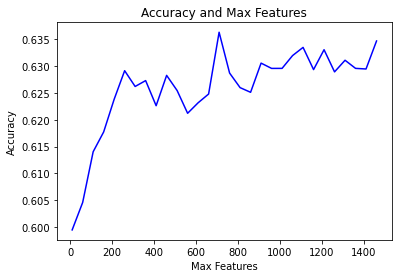

In [104]:
plt.plot(n_features, accuracies, color = 'blue')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Accuracy and Max Features')
plt.show() 

In [15]:
def error_decomposition(x, y, n = 7, model = ensemble.RandomForestClassifier()):
    sample = len(x)//n

    accuracies = []
    false_positives = []
    false_negatives = []
    all_preds = np.zeros(shape = len(y))
    all_indexes = np.arange(len(x))

    for i in range(n):
        test_indexes = np.random.choice(all_indexes, size = sample, replace = False)
        train_indexes = [j for j in range(len(y)) if j not in test_indexes]
        train_x = x[train_indexes]
        test_x = x[test_indexes]

        train_y = y[train_indexes]
        test_y = y[test_indexes]

        model.fit(train_x, train_y)
        preds = model.predict(test_x)
        all_preds[len(test_x)*i:len(test_x)*(i+1)] = preds

        correct = 0
        false_positive = 0
        false_negative = 0

        for k in range(len(preds)):
            if test_y[k] == preds[k]:
                correct += 1
            elif test_y[k] == 0 and preds[k] == 1:
                false_positive += 1
            elif test_y[k] == 1 and preds[k] == 0:
                false_negative += 1
                
        all_indexes = list(all_indexes)
        for index in test_indexes:
            all_indexes.remove(index)
        all_indexes = np.array(all_indexes)
        
        accuracies.append(correct*100/sample)
        false_positives.append(false_positive*100/sample)
        false_negatives.append(false_negative*100/sample)
    
    return np.mean(accuracies), np.mean(false_positives), np.mean(false_negatives), all_preds

In [12]:
# False Positives and Negatives

all_disagreements = list(disagreements['Words'])
all_disagreements = [' '.join(all_disagreements[i].split(',')) for i in range(len(all_disagreements))]
vectorizer = CountVectorizer(max_features=750, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_disagreements).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [18]:
y = np.array(disagreements['sr_disagreement'])
accuracy, false_positive, false_negative, all_preds = error_decomposition(X, y)
print(accuracy, false_positive, false_negative, all_preds.sum()/len(all_preds))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:52<00:00, 16.13s/it]

73.54859752120026 25.701239399869536 0.7501630789302022 0.9788411458333334


In [21]:
print(disagreements[disagreements['sr_disagreement'] == 1].shape[0]/disagreements.shape[0])

0.7314453125


In [20]:
y = np.array(disagreements['ir_disagreement'])
accuracy, false_positive, false_negative, all_preds = error_decomposition(X, y)
print(accuracy, false_positive, false_negative, all_preds.sum()/len(all_preds))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:32<00:00, 13.16s/it]

62.62230919765166 31.050228310502284 6.327462491846054 0.8343098958333334


In [22]:
print(disagreements[disagreements['ir_disagreement'] == 1].shape[0]/disagreements.shape[0])

0.5885416666666666


In [71]:
# Training Accuracy

y = np.array(disagreements['ir_disagreement'])
vectorizer = CountVectorizer(max_features=750, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_disagreements).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
model = ensemble.RandomForestClassifier()
model.fit(X, y)
preds = np.array(model.predict(X))

In [76]:
train_acc = (y == preds).sum()*100/len(y)
print(f'Training Accuracy: {train_acc}%')

Training Accuracy: 99.64192708333333%


In [101]:
#Leaf size comparison

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
min_samples = np.arange(250,300,10)
cv_acc = []
train_acc = []

for i in tqdm(range(len(min_samples))):
    model = ensemble.RandomForestClassifier(min_samples_split = min_samples[i])
    model.fit(X,y)
    preds = np.array(model.predict(X))
    train_acc.append((y == preds).sum()/len(y))
    scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
    cv_acc.append(np.mean(scores))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [13:17<00:00, 159.43s/it]


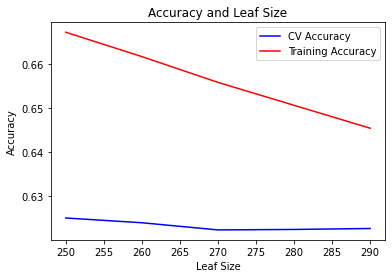

In [102]:
plt.plot(min_samples, cv_acc, color = 'blue', label = 'CV Accuracy')
plt.plot(min_samples, train_acc, color = 'red', label = 'Training Accuracy')
plt.xlabel('Leaf Size')
plt.ylabel('Accuracy')
plt.title('Accuracy and Leaf Size')
plt.legend()
plt.show()

## KNN

In [13]:
# Inputs

disagreements = pd.read_csv('Disagreements_Processed_Complete.csv').drop('Unnamed: 0', axis = 1)
all_disagreements = list(disagreements['Words'])
all_disagreements = [all_disagreements[i].split(',') for i in range(len(all_disagreements))]
doc2vec = Doc2Vec.load('Disagreements_20_Regressors')
x = [doc2vec.infer_vector(all_disagreements[i]) for i in range(len(all_disagreements))]
x = np.array(x).reshape(-1, 20)
y = list(disagreements['ir_disagreement'])

In [33]:
model = KNeighborsClassifier(n_neighbors=10, weights = 'distance')
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
print(scores.mean())

0.6015537199579389


In [30]:
# Comparison of Number of Neighbours

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
all_scores = []
n_neighbors = np.arange(2,100)
for i in range(2, 100):
    model = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
    all_scores.append(np.mean(scores))

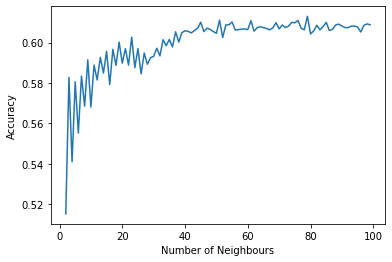

In [32]:
plt.plot(n_neighbors, all_scores)
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.show()

In [35]:
# Comparison of Number of Neighbours with Weights

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
all_scores = []
n_neighbors = np.arange(2,100)
for i in range(2, 100):
    model = KNeighborsClassifier(n_neighbors=i, weights = 'distance')
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv)
    all_scores.append(np.mean(scores))

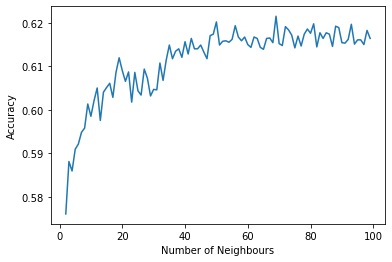

In [36]:
plt.plot(n_neighbors, all_scores)
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.show()

In [42]:
# GridSearch CV

start = time.time()
parameters = {"n_neighbors": range(30, 60), "weights": ["distance"]}
grid_model = GridSearchCV(KNeighborsClassifier(), parameters)
scores = cross_val_score(grid_model, x, y, scoring='accuracy', cv=cv)
end = time.time()

print(np.mean(scores))
print(f'Execution Time: {end-start} seconds')

0.6136076922734021
Execution Time: 120.56499004364014 seconds


In [44]:
grid_model.fit(x,y)
best_k = grid_model.best_params_["n_neighbors"]
best_weights = grid_model.best_params_["weights"]
print(best_k)

52


In [45]:
# Bagging
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
start = time.time()
bagged_knn = KNeighborsClassifier(n_neighbors = best_k, weights = best_weights)
bagging_model = BaggingClassifier(bagged_knn, n_estimators=50)
scores = cross_val_score(bagging_model, x, y, scoring='accuracy', cv=cv)
end = time.time()
print(np.mean(scores))
print(f'Execution Time: {end-start} seconds')

0.6152360050540848
Execution Time: 31.234883308410645 seconds


In [47]:
# Bagging Comparison

n_estimators = np.arange(10, 100, 5)
bagging_scores = []

for i in range(len(n_estimators)):
    bagging_model = BaggingClassifier(bagged_knn, n_estimators = n_estimators[i])
    scores = cross_val_score(bagging_model, x, y, scoring='accuracy', cv=cv)
    bagging_scores.append(np.mean(scores))

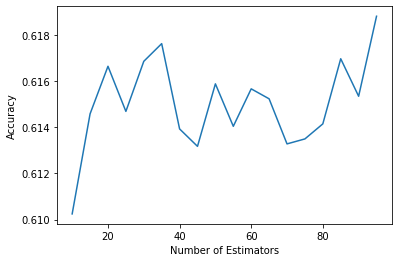

In [48]:
plt.plot(n_estimators, bagging_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()

In [51]:
# Fusion

start = time.time()
all_disagreements = list(disagreements['Words'])
vectorizer = CountVectorizer(max_features=750, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_disagreements).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

bagged_knn = KNeighborsClassifier(n_neighbors = best_k, weights = best_weights)
bagging_model = BaggingClassifier(bagged_knn, n_estimators=50)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
end = time.time()
print(np.mean(scores))
print(f'Execution Time: {end-start} seconds')

0.6233716253062838
Execution Time: 35.006187438964844 seconds


## SVM

In [66]:
def svm(C, degree, x, y):
    cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
    from sklearn import svm
    start = time.time()
    model = svm.SVC(C = C, degree = degree)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv)
    end = time.time()
    print(f'Execution Time: {(end-start)/60} minutes')
    return np.mean(scores)

In [55]:
start = time.time()
svm_model = svm.SVC()
scores = cross_val_score(model, X, y, scoring='accuracy', cv = cv)
end = time.time()
print(np.mean(scores))
print(f'Execution Time: {end-start} seconds')

0.6215261216041321
Execution Time: 2.7766807079315186 seconds


In [60]:
start = time.time()
svm_model = svm.SVC(C = 1.5, degree = 2)
scores = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv)
end = time.time()

print(np.mean(scores))
print(f'Execution Time: {end-start} seconds')

0.6289056598913997
Execution Time: 214.90531277656555 seconds


## Cosine Similarity

In [23]:
def cos_sim(x,y):
    x = np.array(x)
    y = np.array(y)
    num = (x*y).sum()
    den = np.sqrt((x**2).sum()*(y**2).sum())
    return num/den

In [13]:
model = Doc2Vec.load('Disagreements_20_Regressors')

In [20]:
ir = list(disagreements.loc[disagreements['ir_disagreement'] == 1, 'Words'].reset_index(drop = True))
no_ir = (disagreements.loc[disagreements['ir_disagreement'] == 0, 'Words'].reset_index(drop = True))
ir = [ir[i].split(',') for i in range(len(ir))]
no_ir = [no_ir[i].split(',') for i in range(len(no_ir))]
ir_vec = [model.infer_vector(ir[i]) for i in tqdm(range(len(ir)))]
no_ir_vec = [model.infer_vector(no_ir[i]) for i in tqdm(range(len(no_ir)))]

In [24]:
ir_sims = []
no_ir_sims = []
ir_indexes = np.arange(len(ir_vec))
no_ir_indexes = np.arange(len(no_ir_vec))

for i in tqdm(range(len(ir_vec))):
    same = np.random.choice(ir_indexes, replace = True)
    different = np.random.choice(no_ir_indexes, replace = True)
    ir_sims.append(cos_sim(ir_vec[i], ir_vec[same]))
    no_ir_sims.append(cos_sim(ir_vec[i], no_ir_vec[different]))

100%|██████████████████████████████████████████████████████████████████████████████████| 1808/1808 [00:00<00:00, 7469.67it/s]


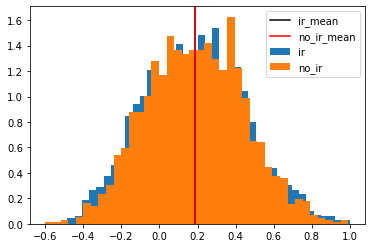

In [31]:
plt.hist(ir_sims, bins = 40, density = True, label = 'ir')
plt.axvline(np.mean(ir_sims), color = 'black', label = 'ir_mean')
#plt.show()
plt.hist(no_ir_sims, bins = 40, density = True, label = 'no_ir')
plt.axvline(np.mean(no_ir_sims), color = 'red', label = 'no_ir_mean')
plt.legend()
plt.show()

In [27]:
sr = list(disagreements.loc[disagreements['sr_disagreement'] == 1, 'Words'].reset_index(drop = True))
no_sr = (disagreements.loc[disagreements['sr_disagreement'] == 0, 'Words'].reset_index(drop = True))
sr = [sr[i].split(',') for i in range(len(sr))]
no_sr = [no_sr[i].split(',') for i in range(len(no_sr))]

sr_vec = [model.infer_vector(sr[i]) for i in tqdm(range(len(sr)))]
no_sr_vec = [model.infer_vector(no_sr[i]) for i in tqdm(range(len(no_sr)))]

100%|██████████████████████████████████████████████████████████████████████████████████████| 825/825 [01:35<00:00,  8.62it/s]


In [29]:
sr_sims = []
no_sr_sims = []
sr_indexes = np.arange(len(sr_vec))
no_sr_indexes = np.arange(len(no_sr_vec))

for i in tqdm(range(len(sr_vec))):
    same = np.random.choice(sr_indexes, replace = True)
    different = np.random.choice(no_sr_indexes, replace = True)
    sr_sims.append(cos_sim(sr_vec[i], sr_vec[same]))
    no_sr_sims.append(cos_sim(sr_vec[i], no_sr_vec[different]))

100%|██████████████████████████████████████████████████████████████████████████████████| 2247/2247 [00:00<00:00, 5687.26it/s]


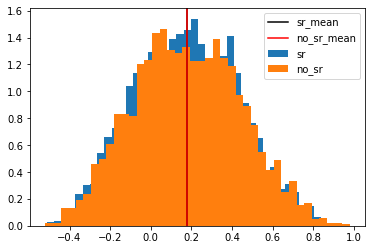

In [32]:
plt.hist(sr_sims, bins = 40, density = True, label = 'sr')
#plt.show()
plt.hist(no_sr_sims, bins = 40, density = True, label = 'no_sr')
plt.axvline(np.mean(sr_sims), color = 'black', label = 'sr_mean')
plt.axvline(np.mean(no_sr_sims), color = 'red', label = 'no_sr_mean')
plt.legend()
plt.show()

## PCA

In [32]:
pca = PCA(2)
pca.fit(X)
X_reduced = pca.transform(X)

y = list(disagreements['ir_disagreement'])
model = ensemble.RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
scores = cross_val_score(model, X_reduced, y, scoring='accuracy', cv=cv)
print(np.mean(scores))

#print(pca.components_)
#print(pca.explained_variance_)

0.5425349969613084


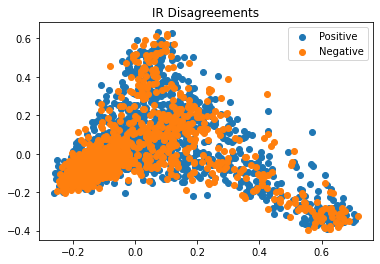

In [44]:
y = np.array(disagreements['ir_disagreement'])
x_pos = X_reduced[y == 1]
x_neg = X_reduced[y == 0]

plt.scatter(x_pos[:, 0], x_pos[:, 1], label = 'Positive')
plt.scatter(x_neg[:, 0], x_neg[:, 1], label = 'Negative')
plt.title('IR Disagreements')
plt.legend()
plt.show()

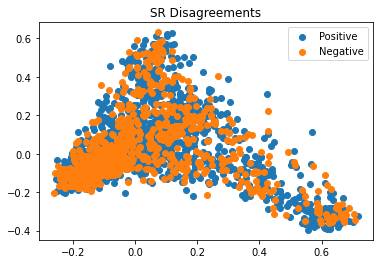

In [48]:
y = np.array(disagreements['sr_disagreement'])
x_pos = X_reduced[y == 1]
x_neg = X_reduced[y == 0]

plt.scatter(x_pos[:, 0], x_pos[:, 1], label = 'Positive')
plt.scatter(x_neg[:, 0], x_neg[:, 1], label = 'Negative')
plt.title('SR Disagreements')
plt.legend()
plt.show()

In [67]:
# Both disagreements

disagreements['both_disagreement'] = disagreements.apply(lambda x: ((x['ir_disagreement'] == 1)&(x['sr_disagreement'] == 1))*1, axis = 1)
#disagreements.drop(['Disagreement', 'disagreement'], axis = 1, inplace = True)
disagreements[disagreements['both_disagreement'] == 1].head()

,s_courty,CaseNumber,s_URL,sr_disagreement,ir_disagreement,Words,both_disagreement
2,1,No. 03-1453.,https://www.leagle.com/decision/2004585370f3d2...,1,1,"united,state,court,appeal,first,circuit,torrue...",1
5,1,No. 03-1841.,https://www.leagle.com/decision/2005521424f3d9...,1,1,"united,state,court,appeal,first,circuit,boudin...",1
9,1,No. 04-1776.,https://www.leagle.com/decision/2005745428f3d3...,1,1,"united,state,court,appeal,first,circuit,lipez,...",1
10,1,No. 04-2101.,https://www.leagle.com/decision/2005448423f3d2...,1,1,"united,state,court,appeal,first,circuit,hill,c...",1
14,1,No. 05-1121.,https://www.leagle.com/decision/2006581443f3d1...,1,1,"united,state,court,appeal,first,circuit,torrue...",1


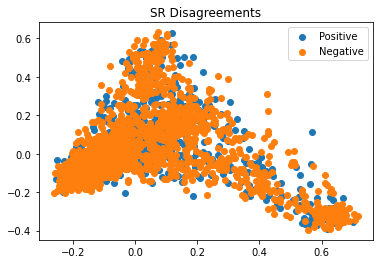

In [68]:
y = np.array(disagreements['both_disagreement'])
x_pos = X_reduced[y == 1]
x_neg = X_reduced[y == 0]

plt.scatter(x_pos[:, 0], x_pos[:, 1], label = 'Positive')
plt.scatter(x_neg[:, 0], x_neg[:, 1], label = 'Negative')
plt.title('Both Disagreements')
plt.legend()
plt.show()

## Sanity Check

In [16]:
all_disagreements = list(disagreements['Words'])
vectorizer = CountVectorizer(max_features=750, max_df=0.9, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(all_disagreements).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
y = np.array(disagreements['ir_disagreement'])

cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)
min_samples = np.arange(10,200,10)
cv_acc = []
train_acc = []
pos_preds = []
false_positives = []
false_negatives = []

for i in tqdm(range(len(min_samples))):
    model = ensemble.RandomForestClassifier(min_samples_split = min_samples[i])
    model.fit(X,y)
    preds = np.array(model.predict(X))
    train_acc.append((y == preds).sum()/len(y))
    accuracy, false_positive, false_negative, all_preds = error_decomposition(X, y, model = model)
    cv_acc.append(accuracy)
    pos_preds.append(all_preds.sum()/len(all_preds))
    false_positives.append(false_positive)
    false_negatives.append(false_negative)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [39:25<00:00, 124.52s/it]


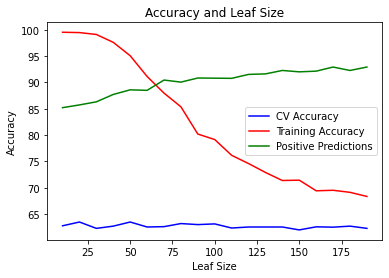

In [17]:
plt.plot(min_samples, cv_acc, color = 'blue', label = 'CV Accuracy')
plt.plot(min_samples, np.array(train_acc)*100, color = 'red', label = 'Training Accuracy')
plt.plot(min_samples, np.array(pos_preds)*100, color = 'green', label = 'Positive Predictions')
plt.xlabel('Leaf Size')
plt.ylabel('Accuracy')
plt.title('Accuracy and Leaf Size')
plt.legend()
plt.show()

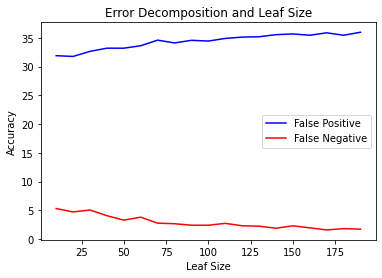

In [18]:
plt.plot(min_samples, false_positives, color = 'blue', label = 'False Positive')
plt.plot(min_samples, false_negatives, color = 'red', label = 'False Negative')
plt.xlabel('Leaf Size')
plt.ylabel('Error Rates')
plt.title('Error Decomposition and Leaf Size')
plt.legend()
plt.show()